In [1]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist
import pickle
from time import ctime
import matplotlib.pyplot as plt
import pyomo.environ as pyo
from pyomo.opt import SolverFactory
from pyomo.core.base import Constraint as pyo_constraint
from pyomo.core.base import Var as pyo_vars

### Data processing functions

In [65]:
def load_input_data(input_data, input_file_location=None):
    """
    Return input data as numpy arrays in a dictionary.
    """

    # parse the input
    lines = input_data.split('\n')

    firstLine = lines[0].split()
    num_facilities = int(firstLine[0])
    num_customers = int(firstLine[1])
    
    data_dict = {}
    data_dict['num_facilities'] = num_facilities
    data_dict['num_customers'] = num_customers

    facility_cost_array = np.zeros(num_facilities)
    facility_capacity_array = np.zeros(num_facilities)
    facility_location_array = np.zeros((num_facilities, 2))
    for i in range(num_facilities):
        line = lines[i + 1]
        parts = line.split()
        facility_cost_array[i] = parts[0]
        facility_capacity_array[i] = parts[1]
        facility_location_array[i,:] = np.array([parts[2], parts[3]])
        
    data_dict['facility_cost_array'] = facility_cost_array
    data_dict['facility_capacity_array'] = facility_capacity_array
    data_dict['facility_location_array'] = facility_location_array

    customer_demand_array = np.zeros(num_customers)
    customer_location_array = np.zeros((num_customers, 2))
    for i in range(num_customers):
        line = lines[i + 1 + num_facilities]
        parts = line.split()
        customer_demand_array[i] = parts[0]
        customer_location_array[i,:] = np.array([parts[1], parts[2]])
        
    data_dict['customer_demand_array'] = customer_demand_array
    data_dict['customer_location_array'] = customer_location_array
    
    
    filelist = ['fl_25_2', 'fl_50_6', 'fl_100_7', 'fl_100_1', 
                'fl_200_7', 'fl_500_7', 'fl_1000_2', 'fl_2000_2']
    
    if input_file_location is not None:
        for counter, filename in enumerate(filelist):
            if filename == input_file_location.split('/')[-1]:
                data_dict['problem_number'] = counter
        
    
    return data_dict

In [69]:
input_file = open('data/fl_100_1','r').read()

In [70]:
data_dict = load_input_data(input_file)#, 'data/fl_500_7')

In [71]:
data_dict

{'num_facilities': 100,
 'num_customers': 1000,
 'facility_cost_array': array([2141200., 2107403., 1840969., 2217151., 2164343., 2158091.,
        2223692., 2113995., 1669402., 1846084., 1485698., 1628333.,
        1686024., 2244889., 1948452., 1536462., 1853838., 1986043.,
        2155053., 1435703., 1740862., 1830706., 1687608., 1666265.,
        2237235., 1566314., 2061436., 1592113., 2110304., 1479013.,
        1723130., 1888824., 1559456., 1402362., 1479901., 1459359.,
        1898083., 1859829., 2013552., 1909519., 1891834., 1544585.,
        2116415., 2194426., 2042697., 1936576., 1810348., 1714556.,
        1374042., 1504878., 1843254., 1578148., 1557988., 1655721.,
        1812125., 2210475., 1396759., 1703038., 1562645., 1444648.,
        1898165., 1627211., 2012772., 1939489., 1529233., 1935370.,
        1552478., 1497012., 1444604., 1380954., 1369874., 1940815.,
        2253906., 1708404., 1849153., 2143143., 1781490., 2228610.,
        1479404., 1990010., 1866115., 1680386

In [62]:
def get_solution(data_dict, results_dict):
    
    solution = np.zeros(len(data_dict['customer_location_array']))
    for facility, customer_list in results_dict['facility_customers'].items():
        solution[customer_list] = facility
        
    return solution.astype(int)

In [28]:
solution = get_solution(data_dict, greedy_results_dict)
solution

array([131,  33, 359, ..., 378, 207, 118])

In [10]:
def prepare_output_data(data_dict, results_dict, is_provably_optimal=False):
    """
    Return output in specified format.
    """
    
    if is_provably_optimal:
        optimal = str(1)
    else:
        optimal = str(0)
        
    solution = get_solution(data_dict, results_dict)
    
    output_data = str(results_dict['objective_value']) + ' ' + optimal + '\n'
    output_data += ' '.join(map(str, solution.astype(int)))
    
    return output_data

In [152]:
prepare_output_data(data_dict, results_dict, is_provably_optimal=False)

In [9]:
def create_facility_customer_dist_matrix(data_dict):
    
    """
    Distance matrix between facilities (rows) and customers (columns)
    """
    
    return cdist(data_dict['facility_location_array'], data_dict['customer_location_array'])

In [72]:
facility_customer_dist_matrix = cdist(data_dict['facility_location_array'], data_dict['customer_location_array'])
facility_customer_dist_matrix

array([[ 469.51890271,  470.93311627,  472.34732983,  677.40829638],
       [ 473.76154339,  475.17575696,  476.58997052,  673.16565569],
       [1975.65634664, 1977.0705602 , 1978.48477376,  828.72914755]])

### Write a greedy algorithm to solve

In [4]:
def greedy_algorithm(data_dict, facility_customer_dist_matrix=None):
    
    if facility_customer_dist_matrix is None:
        facility_customer_dist_matrix = create_facility_customer_dist_matrix(data_dict)
        
    facility_cost_array = data_dict['facility_cost_array']
    facility_capacity_array = data_dict['facility_capacity_array']
    customer_demand_array  = data_dict['customer_demand_array']
    facility_location_array  = data_dict['facility_location_array']
    customer_location_array  = data_dict['customer_location_array']
    
    num_customers = len(customer_demand_array)
    num_facilities = len(facility_capacity_array)
    
    facility_customers = {}
    fixed_costs = 0
    transport_costs = 0
    
    facility_remaining_capacity = {counter: facility_capacity_array[counter] 
                                   for counter in range(num_facilities)}
    
    customer_ordering = np.argsort(np.min(facility_customer_dist_matrix, axis=0))
    
    for customer in customer_ordering:
        closest_facility_indexes = np.argsort(facility_customer_dist_matrix[:, customer])
        customer_demand = customer_demand_array[customer]
        customer_allocated = False
        counter = 0
        #print('customer: ' + str(customer))
        #print('customer_demand: ' + str(customer_demand))
        while not customer_allocated:
            facility = closest_facility_indexes[counter]
            #print('facility: ' + str(facility))
            #print('facility capacity: ' +str(facility_remaining_capacity[facility]))
            if facility in facility_customers.keys():
                if facility_remaining_capacity[facility] >= customer_demand:
                    facility_customers[facility].append(customer)
                    facility_remaining_capacity[facility] -= customer_demand
                    transport_costs += facility_customer_dist_matrix[facility, customer]
                    customer_allocated = True
                    #print('used facility ' + str(facility))
                else:
                    counter += 1
            else:
                facility_customers[facility] = [customer]
                facility_remaining_capacity[facility] -= customer_demand
                fixed_costs += facility_cost_array[facility]
                transport_costs += facility_customer_dist_matrix[facility, customer]
                customer_allocated = True
                #print('used facility ' + str(facility))
        #print(' ')
        
    out_dict = {}
    out_dict['facility_customers'] = facility_customers
    out_dict['fixed_costs'] = fixed_costs
    out_dict['transport_costs'] = transport_costs
    out_dict['objective_value'] = fixed_costs + transport_costs
    out_dict['is_optimal'] = False
        
    return out_dict
                

In [11]:
greedy_results_dict = greedy_algorithm(data_dict)
greedy_results_dict

{'facility_customers': {132: [789],
  429: [1302, 334, 345, 569, 1626, 2866, 2622, 352],
  375: [2798, 1832, 163],
  297: [951, 460, 2121, 2926, 1585, 2836, 2096],
  135: [2189, 1757, 2241, 424],
  160: [2546, 1779, 336, 362, 2633],
  20: [33, 1400, 2178],
  6: [72, 246, 1351, 2982, 167, 1009, 732, 1859, 575, 2019, 2728, 962],
  424: [882, 1154, 1292],
  367: [505, 2261, 2118, 2758, 1085, 1926, 2092, 2276, 679, 1857],
  338: [1816, 830, 2956, 2919, 44, 2186, 1815, 2737, 1325],
  324: [313, 2586, 1510, 1451, 226, 2717, 2742, 2342, 1285, 170],
  307: [2259, 878, 2134, 2545, 1498, 2559, 711, 2543],
  450: [368,
   1519,
   1353,
   100,
   1107,
   2285,
   2242,
   2538,
   2510,
   1648,
   2600,
   338,
   477,
   994],
  216: [2899,
   2101,
   1284,
   1469,
   2832,
   2705,
   918,
   2027,
   1683,
   564,
   2943,
   2745,
   1645,
   2784],
  70: [2702, 291, 2428, 2933, 2252, 2591],
  45: [109, 131, 937, 1701, 560, 773, 2212, 1470, 997],
  285: [1939, 2411, 1606, 1289, 1005],
  

### Write and solve the optimisation model with Pyomo and CBC/CPLEX

In [9]:
def get_closest_facilities_to_customers(data_dict, closest_percentage=0.25, facility_customer_dist_matrix=None):
    
    if facility_customer_dist_matrix is None:
        facility_customer_dist_matrix = create_facility_customer_dist_matrix(data_dict)
                                             
    num_facilities = max(1, int(facility_customer_dist_matrix.shape[0]*closest_percentage))
            
    customer_closest_facilities_dict = {}
    for customer in range(facility_customer_dist_matrix.shape[1]):
        customer_closest_facilities = np.argsort(facility_customer_dist_matrix[:,customer])[:num_facilities]
        for facility in range(facility_customer_dist_matrix.shape[0]):
            if facility in customer_closest_facilities:
                customer_closest_facilities_dict[(facility, customer)] = 1
            else:
                customer_closest_facilities_dict[(facility, customer)] = 0
    
    return customer_closest_facilities_dict

In [87]:
get_closest_facilities_to_customers(data_dict)

{(0, 0): 0,
 (1, 0): 0,
 (2, 0): 1,
 (3, 0): 0,
 (4, 0): 0,
 (5, 0): 0,
 (6, 0): 0,
 (7, 0): 0,
 (8, 0): 1,
 (9, 0): 0,
 (10, 0): 0,
 (11, 0): 0,
 (12, 0): 0,
 (13, 0): 0,
 (14, 0): 0,
 (15, 0): 0,
 (16, 0): 0,
 (17, 0): 0,
 (18, 0): 0,
 (19, 0): 0,
 (20, 0): 0,
 (21, 0): 1,
 (22, 0): 1,
 (23, 0): 1,
 (24, 0): 0,
 (25, 0): 0,
 (26, 0): 0,
 (27, 0): 1,
 (28, 0): 0,
 (29, 0): 1,
 (30, 0): 0,
 (31, 0): 1,
 (32, 0): 1,
 (33, 0): 0,
 (34, 0): 0,
 (35, 0): 1,
 (36, 0): 0,
 (37, 0): 1,
 (38, 0): 0,
 (39, 0): 0,
 (40, 0): 0,
 (41, 0): 0,
 (42, 0): 0,
 (43, 0): 1,
 (44, 0): 0,
 (45, 0): 0,
 (46, 0): 0,
 (47, 0): 0,
 (48, 0): 0,
 (49, 0): 1,
 (50, 0): 0,
 (51, 0): 0,
 (52, 0): 1,
 (53, 0): 0,
 (54, 0): 1,
 (55, 0): 0,
 (56, 0): 0,
 (57, 0): 1,
 (58, 0): 0,
 (59, 0): 0,
 (60, 0): 0,
 (61, 0): 1,
 (62, 0): 0,
 (63, 0): 1,
 (64, 0): 1,
 (65, 0): 0,
 (66, 0): 1,
 (67, 0): 0,
 (68, 0): 1,
 (69, 0): 0,
 (70, 0): 0,
 (71, 0): 1,
 (72, 0): 0,
 (73, 0): 1,
 (74, 0): 0,
 (75, 0): 0,
 (76, 0): 0,
 (77, 0):

In [12]:
def objective_function(model):
    
    return sum(model.fixed_costs[f] * model.x[f] for f in model.F) \
         + sum(sum(model.transport_costs[f, c] * model.y[f, c] for f in model.F) for c in model.C)

In [13]:
def constraint_open_facilities(model, f, c):
    
    return model.y[f, c] <= model.x[f]

def constraint_customer_assigned(model, c):
    
    return sum(model.y[f, c] for f in model.F) == 1

def constraint_capacity(model, f):
    
    return sum(model.demands[c] * model.y[f, c] for c in model.C) <= model.capacities[f]

def constraint_customer_use_close_facilities(model, f, c):
    
    return model.y[f, c] <= model.closest_facilities_to_customers_dict[(f, c)]

In [13]:
def build_model(data_dict, facility_customer_dist_matrix=None, closest_facilities_to_customers_dict=None):
    
    if facility_customer_dist_matrix is None:
        facility_customer_dist_matrix = create_facility_customer_dist_matrix(data_dict)
        
    if closest_facilities_to_customers_dict is None:
        closest_facilities_to_customers_dict = get_closest_facilities_to_customers(data_dict) 
    
    facility_cost_array = data_dict['facility_cost_array']
    facility_capacity_array = data_dict['facility_capacity_array']
    customer_demand_array  = data_dict['customer_demand_array']
    
    model = pyo.ConcreteModel()
    
    model.F = pyo.Set(initialize=[f for f in range(len(facility_cost_array))])
    model.C = pyo.Set(initialize=[c for c in range(len(customer_demand_array))])
    
    model.fixed_costs = pyo.Param(model.F, within=pyo.NonNegativeReals, 
                                  initialize={counter: element for counter, element in 
                                              enumerate(facility_cost_array)}, default=0.0)
    model.transport_costs = pyo.Param(model.F, model.C, within=pyo.NonNegativeReals, 
                                      initialize={(counter_1, counter_2): facility_customer_dist_matrix[counter_1, counter_2] 
                                                  for counter_1 in range(len(facility_cost_array))
                                                  for counter_2 in range(len(customer_demand_array))}, 
                                      default=0.0)
    model.demands = pyo.Param(model.C, within=pyo.NonNegativeReals, 
                              initialize={counter: element for counter, element in 
                                          enumerate(customer_demand_array)}, default=0.0)
    model.capacities = pyo.Param(model.F, within=pyo.NonNegativeReals, 
                                 initialize={counter: element for counter, element in 
                                             enumerate(facility_capacity_array)}, default=0.0)
    
    model.closest_facilities_to_customers_dict = pyo.Param(model.F, model.C, within=pyo.NonNegativeReals, 
                                                           initialize=closest_facilities_to_customers_dict, 
                                                           default=0.0)
    
    model.x = pyo.Var(model.F, within=pyo.Binary)
    model.y = pyo.Var(model.F, model.C, within=pyo.Binary)
    
    model.objective_function = pyo.Objective(rule=objective_function, sense=pyo.minimize)
    model.constraint_open_facilities = pyo.Constraint(model.F, model.C, rule=constraint_open_facilities)
    model.constraint_customer_assigned = pyo.Constraint(model.C, rule=constraint_customer_assigned)
    model.constraint_capacity = pyo.Constraint(model.F, rule=constraint_capacity)
    
    
    model.constraint_customer_use_close_facilities = pyo.Constraint(model.F, model.C, 
                                                                    rule=constraint_customer_use_close_facilities)
    
    return model

In [16]:
def solve_model_milp(model, solver_name, solver_path, timeout_time=120, ratio_gap=0.01, show_working=True):
    
    print('Run start time: ' + str(ctime()))
    
    # Use CPLEX on the NEOS server
    if solver_name == 'cplex':
        manager = pyo.SolverManagerFactory('neos')
        opt_settings = SolverFactory(solver_name)
        opt_settings.set_options('mipgap=' + str(ratio_gap))
        opt_settings.set_options('timelimit=' + str(timeout_time))
        opt_settings.set_options('mipdisplay=' + str(3))
        opt_settings.set_options('nodefile=' + str(2))
        opt_settings.set_options('treememory=' + str(10000))
        results = manager.solve(model, opt=opt_settings, keepfiles=True)
        
    elif solver_name == 'cbc':
        opt_settings = SolverFactory(solver_name, executable=solver_path)
        opt_settings.set_options('sec=' + str(timeout_time))
        opt_settings.set_options('ratioGap=' + str(ratio_gap))
        results = opt_settings.solve(model, tee=show_working)
        
    else:
        raise ValueError(f'Solver {solver_name} not supported')
        
    print('Run finish time: ' + str(ctime()))        
    
    return model, results

In [15]:
model_instance = build_model(data_dict)

In [99]:
model_instance, results_instance = solve_model_milp(model_instance, 'cbc', 
                                                    r'C:\repos\coursera_discrete_optimization\solvers\cbc\bin\cbc.exe',
                                                    timeout_time=600, ratio_gap=0, show_working=True)

Run start time: Thu Feb  6 16:58:01 2020
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Jun 15 2019 

command line - C:\repos\coursera_discrete_optimization\solvers\cbc\bin\cbc.exe -sec 600 -ratioGap 0 -printingOptions all -import C:\Users\DOMINI~1.WIG\AppData\Local\Temp\tmpvcd607xd.pyomo.lp -stat=1 -solve -solu C:\Users\DOMINI~1.WIG\AppData\Local\Temp\tmpvcd607xd.pyomo.soln (default strategy 1)
seconds was changed from 1e+100 to 600
ratioGap was changed from 0 to 0
Option for printingOptions changed from normal to all
Presolve 26098 (-175003) rows, 25100 (-75001) columns and 99799 (-400202) elements
Statistics for presolved model
Original problem has 100100 integers (100100 of which binary)
Presolved problem has 25100 integers (25100 of which binary)
==== 0 zero objective 25100 different
==== absolute objective values 25100 different
==== for integers 0 zero objective 25100 different
==== for integers absolute objective values 25100 different
===== end objective counts



Cbc0038I Pass  59: (87.86 seconds) suminf.   31.86227 (396) obj. 2.31021e+07 iterations 335
Cbc0038I Pass  60: (88.00 seconds) suminf.   32.21081 (393) obj. 2.31021e+07 iterations 391
Cbc0038I Pass  61: (88.09 seconds) suminf.   32.19966 (393) obj. 2.31021e+07 iterations 142
Cbc0038I Pass  62: (88.31 seconds) suminf.   30.83972 (394) obj. 2.31021e+07 iterations 571
Cbc0038I Pass  63: (88.45 seconds) suminf.   30.81939 (396) obj. 2.31021e+07 iterations 454
Cbc0038I Pass  64: (88.67 seconds) suminf.   33.30910 (387) obj. 2.31021e+07 iterations 648
Cbc0038I Pass  65: (88.86 seconds) suminf.   32.29274 (386) obj. 2.31021e+07 iterations 566
Cbc0038I Pass  66: (89.05 seconds) suminf.   32.30944 (389) obj. 2.31021e+07 iterations 424
Cbc0038I Pass  67: (89.22 seconds) suminf.   31.04683 (388) obj. 2.31021e+07 iterations 352
Cbc0038I Pass  68: (89.46 seconds) suminf.   31.06163 (388) obj. 2.31021e+07 iterations 583
Cbc0038I Pass  69: (89.77 seconds) suminf.   31.28513 (380) obj. 2.31021e+07 ite

Cbc0010I After 2400 nodes, 708 on tree, 22931483 best solution, best possible 21943587 (314.05 seconds)
Cbc0010I After 2500 nodes, 695 on tree, 22931483 best solution, best possible 21943587 (321.22 seconds)
Cbc0010I After 2600 nodes, 673 on tree, 22931483 best solution, best possible 21943587 (326.34 seconds)
Cbc0010I After 2700 nodes, 664 on tree, 22931483 best solution, best possible 21943587 (334.59 seconds)
Cbc0010I After 2800 nodes, 677 on tree, 22931483 best solution, best possible 21943587 (341.04 seconds)
Cbc0010I After 2900 nodes, 598 on tree, 22931483 best solution, best possible 21943587 (348.77 seconds)
Cbc0038I Full problem 26098 rows 25100 columns, reduced to 1322 rows 1070 columns
Cbc0010I After 3000 nodes, 610 on tree, 22931483 best solution, best possible 21943587 (358.68 seconds)
Cbc0010I After 3100 nodes, 622 on tree, 22931483 best solution, best possible 21943587 (363.22 seconds)
Cbc0010I After 3200 nodes, 598 on tree, 22931483 best solution, best possible 21943587

In [ ]:
model_instance, results_instance = solve_model_milp(model_instance, 'cplex', 
                                                    'neos',
                                                    timeout_time=290, ratio_gap=0, show_working=True)

Run start time: Fri Feb  7 00:00:13 2020


In [40]:
def get_results_dict(model, results, data_dict, facility_customer_dist_matrix=None):
    
    if facility_customer_dist_matrix is None:
        facility_customer_dist_matrix = create_facility_customer_dist_matrix(data_dict)
    
    out_dict = {'facility_customers':{}}
    fixed_costs = 0
    transport_costs = 0
    
    for tup, val in model.y.get_values().items():
        facility, customer = tup[0], tup[1]
        if val == 1:
            if facility not in out_dict['facility_customers']:
                out_dict['facility_customers'][facility] = [customer]
                fixed_costs += data_dict['facility_cost_array'][facility]
            else:
                out_dict['facility_customers'][facility].append(customer)
            transport_costs += facility_customer_dist_matrix[facility, customer]
            
    if str(list(results['Solver'])[0]['Termination condition']) == 'optimal':
        is_optimal = True
    else:
        is_optimal = False
            
    out_dict['fixed_costs'] = fixed_costs
    out_dict['transport_costs'] = transport_costs
    out_dict['objective_value'] = fixed_costs + transport_costs
    out_dict['is_optimal'] = is_optimal
    
    solution_array = get_solution(data_dict, out_dict)
    
    out_dict['solution_array'] = solution_array
        
    return out_dict

In [129]:
results_dict = get_results_dict(model_instance, results_instance, data_dict)
results_dict

{'facility_customers': {2: [44, 91, 106, 170, 181],
  3: [7, 15, 99, 186],
  4: [65, 180],
  5: [55, 92, 125, 161, 192],
  6: [75, 78, 101],
  7: [31, 43, 90, 164],
  8: [27, 66, 76, 110, 126, 153, 196],
  9: [8, 22, 24, 32, 37, 49, 56, 64, 89, 108, 111, 136, 138, 143, 149, 185],
  10: [163, 169],
  11: [129, 188],
  13: [25, 109, 124, 172, 194],
  14: [4, 58, 67],
  15: [5, 114],
  16: [16, 103, 107, 119, 156, 182, 189],
  18: [53, 128],
  19: [2, 26, 45, 142],
  24: [1, 9, 13, 29, 30, 79, 83, 85, 86, 96, 115],
  25: [3, 33, 39, 47, 68, 94, 117, 157, 191],
  26: [17, 158],
  28: [0, 36, 38, 70, 121, 141, 144, 145, 175, 184],
  29: [152, 167],
  31: [34, 57, 60, 82, 84, 98, 104, 159, 173, 187, 190, 195],
  33: [35, 71, 179],
  34: [6, 23, 50, 88, 122, 168],
  35: [10, 42, 54, 59, 61, 77, 95, 113, 120, 123, 127, 150, 176],
  38: [28, 40, 130, 139, 140, 151, 160],
  39: [73, 93, 102, 131],
  40: [41, 46, 80, 97, 165, 174, 197],
  41: [12, 21, 48, 52, 72, 133, 137, 147, 171],
  42: [11, 7

In [38]:
solution = get_solution(data_dict, results_dict)
solution

array([28, 24, 19, 25, 14, 15, 34,  3,  9, 24, 35, 42, 41, 24, 49,  3, 16,
       26, 43, 45, 45, 41,  9, 34,  9, 13, 19,  8, 38, 24, 24,  7,  9, 25,
       31, 33, 28,  9, 28, 25, 38, 40, 35,  7,  2, 19, 40, 25, 41,  9, 34,
       44, 41, 18, 35,  5,  9, 31, 14, 35, 31, 35, 44, 43,  9,  4,  8, 14,
       25, 45, 28, 33, 41, 39, 42,  6,  8, 35,  6, 24, 40, 47, 31, 24, 31,
       24, 24, 45, 34,  9,  7,  2,  5, 39, 25, 35, 24, 40, 31,  3, 47,  6,
       39, 16, 31, 44,  2, 16,  9, 13,  8,  9, 47, 35, 15, 24, 43, 25, 42,
       16, 35, 28, 34, 35, 13,  5,  8, 35, 18, 11, 38, 39, 43, 41, 47, 44,
        9, 41,  9, 38, 38, 28, 19,  9, 28, 28, 42, 41, 47,  9, 35, 38, 29,
        8, 45, 49, 16, 25, 26, 31, 38,  5, 49, 10,  7, 40, 44, 29, 34, 10,
        2, 41, 13, 31, 40, 28, 35, 49, 44, 33,  4,  2, 16, 47, 28,  9,  3,
       31, 11, 16, 31, 25,  5, 42, 13, 31,  8, 40, 44, 45])

In [18]:
def get_objective_value_from_solution(solution, data_dict, facility_customer_dist_matrix=None):
    
    if facility_customer_dist_matrix is None:
        facility_customer_dist_matrix = create_facility_customer_dist_matrix(data_dict)
    
    facility_cost_array = data_dict['facility_cost_array']
    
    transport_costs = facility_customer_dist_matrix[solution, 
                                                    np.arange(len(data_dict['customer_location_array']))].sum()
    
    fixed_costs = data_dict['facility_cost_array'][np.unique(solution)].sum()
    
    return transport_costs + fixed_costs

In [39]:
get_objective_value_from_solution(solution, data_dict)

3732793.43377155

In [19]:
def visualise_solution(data_dict, results_dict, facility_customer_dist_matrix=None):
    
    if facility_customer_dist_matrix is None:
        facility_customer_dist_matrix = create_facility_customer_dist_matrix(data_dict)
    
    facility_cost_array = data_dict['facility_cost_array']
    facility_capacity_array = data_dict['facility_capacity_array']
    customer_demand_array  = data_dict['customer_demand_array']
    facility_location_array  = data_dict['facility_location_array']
    customer_location_array  = data_dict['customer_location_array']
    
    fig, ax = plt.subplots(figsize=(10,6))
    ax.set_title('Fixed cost: ' + str(int(results_dict['fixed_costs'])) \
                 + '   Transport costs: ' + str(int(results_dict['transport_costs'])))
    ax.scatter(customer_location_array[:, 0], customer_location_array[:, 1],  marker='+')
    ax.scatter(facility_location_array[:, 0], facility_location_array[:, 1],  marker='H')
    ax.axis('equal')
    
    for facility in range(len(facility_cost_array)):
        facility_location = facility_location_array[facility]
        if facility in results_dict['facility_customers']:
            for customer in results_dict['facility_customers'][facility]:
                customer_location = customer_location_array[customer]
                ax.annotate("",
                            xy=facility_location, xycoords='data',
                            xytext=customer_location, 
                            textcoords='data',
                            arrowprops=dict(arrowstyle="-",
                                            connectionstyle="arc3"))
    
    #plt.tight_layout()
    plt.show()

<IPython.core.display.Javascript object>


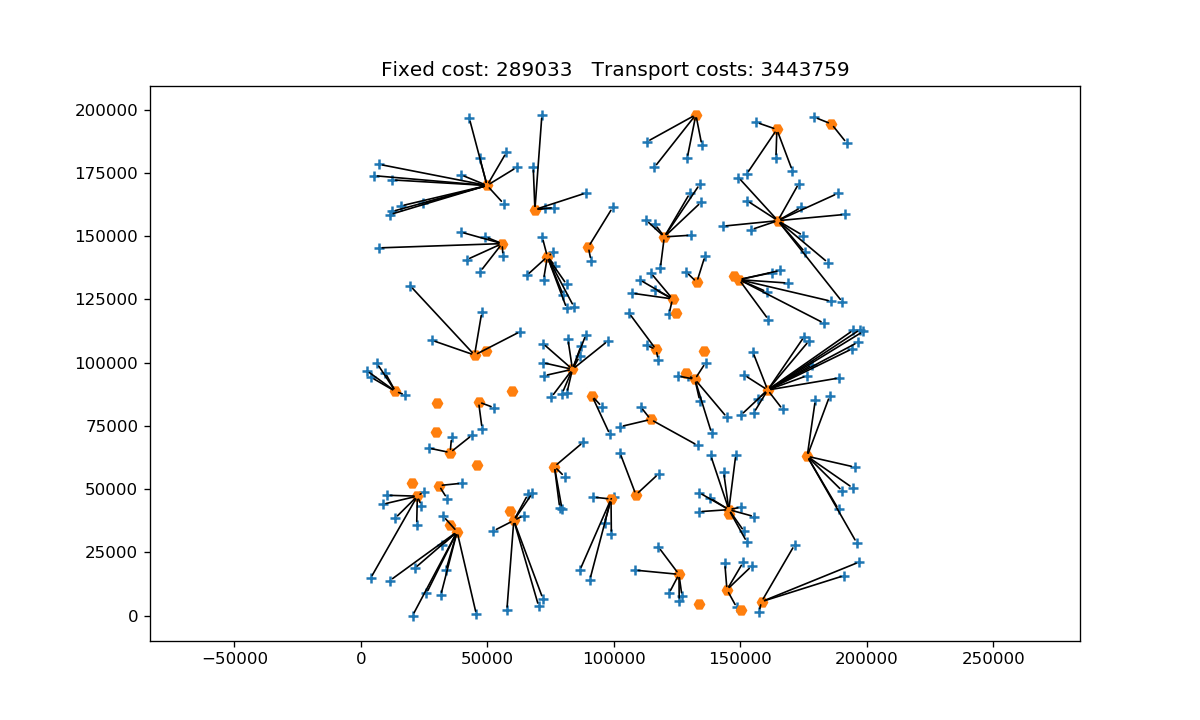

In [40]:
%matplotlib notebook
visualise_solution(data_dict, results_dict)

## Optimal

<IPython.core.display.Javascript object>


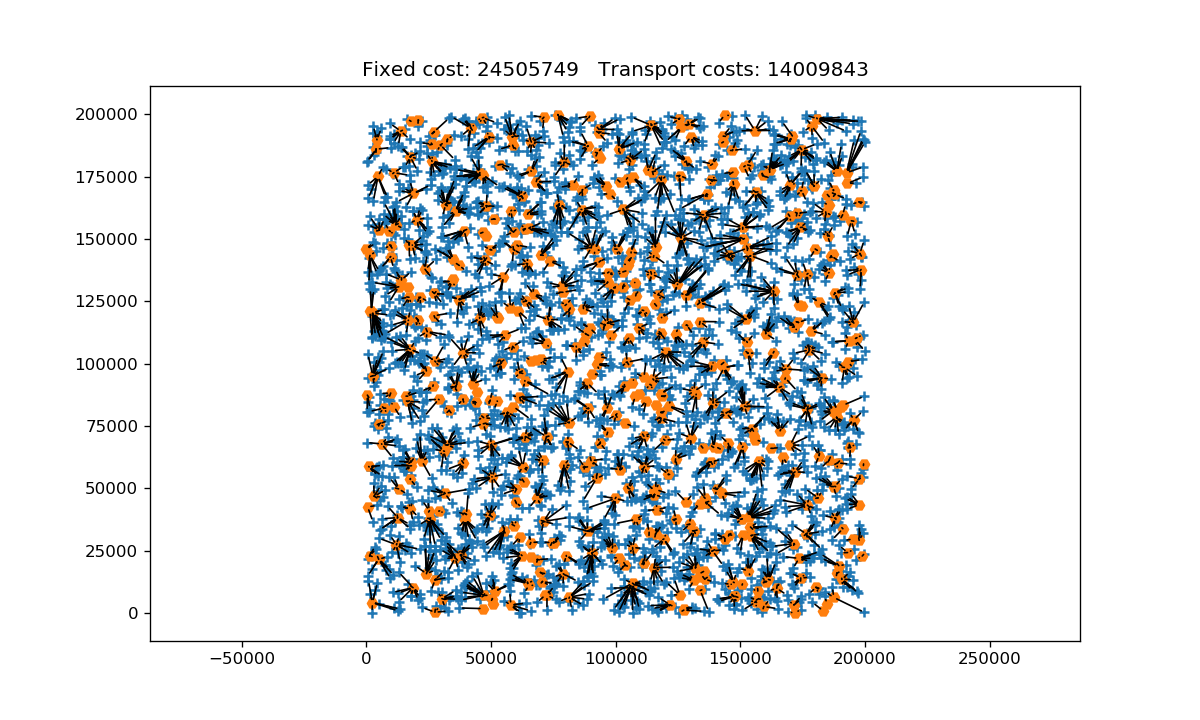

In [98]:
%matplotlib notebook
visualise_solution(data_dict, greedy_results_dict)

## Greedy

### Try a Large Neighbourhood Search algorithm

For a neighbourhood, pick a random part of the map (split it into a grid) and unassign all customers in the grid, as well as all facilities serving these customers and all customers served by those facilities. Solve this subproblem with a IP.



In [20]:
def get_customer_map_corners(customer_location_array):
    
    top_left = [customer_location_array[:,0].min(), customer_location_array[:,1].max()]
    bottom_left = [customer_location_array[:,0].min(), customer_location_array[:,1].min()]
    bottom_right = [customer_location_array[:,0].max(), customer_location_array[:,1].min()]
    top_right = [customer_location_array[:,0].max(), customer_location_array[:,1].max()]
    
    out_dict = {
        'top_left': top_left,
        'bottom_left': bottom_left,
        'bottom_right': bottom_right,
        'top_right': top_right
    }
    
    return out_dict

In [29]:
map_corner_dict = get_customer_map_corners(data_dict['customer_location_array'])
map_corner_dict

{'top_left': [88.08, 199919.66],
 'bottom_left': [88.08, 55.005],
 'bottom_right': [199946.755, 55.005],
 'top_right': [199946.755, 199919.66]}

In [21]:
def interpolate(v1, v2, interp_points, n):
    
    if v1 > v2:
        return v2 + ((v1-v2)/interp_points)*n
    elif v2 > v1:
        return v1 + ((v2-v1)/interp_points)*n
    else:
        return v1

In [18]:
interpolate(10, 20, 10, 11)

21.0

In [22]:
def get_grid_corners(map_corner_dict, num_width_pieces, num_length_pieces,
                     central_width_piece_start_num, central_length_piece_start_num, 
                     width_piece_size = 1, length_piece_size = 1):
    
    width_additional_cells = (width_piece_size-1)/2
    length_additional_cells = (length_piece_size-1)/2
    
    x_left = interpolate(map_corner_dict['bottom_left'][0], 
                         map_corner_dict['bottom_right'][0], 
                         num_width_pieces, max(central_width_piece_start_num - width_additional_cells, 0))
    x_right = interpolate(map_corner_dict['bottom_left'][0], 
                          map_corner_dict['bottom_right'][0], 
                          num_width_pieces, min(central_width_piece_start_num + width_additional_cells + 1, 
                                               num_width_pieces))
    y_bottom = interpolate(map_corner_dict['bottom_left'][1], 
                           map_corner_dict['top_left'][1], 
                           num_length_pieces, max(central_length_piece_start_num - length_additional_cells, 0))
    y_top = interpolate(map_corner_dict['bottom_left'][1], 
                        map_corner_dict['top_left'][1], 
                        num_length_pieces, min(central_length_piece_start_num + length_additional_cells + 1, 
                                               num_length_pieces))
    
    out_dict = {
        'top_left': [x_left, y_top],
        'bottom_left': [x_left, y_bottom],
        'bottom_right': [x_right, y_bottom],
        'top_right': [x_right, y_top]
    }
    
    return out_dict

In [30]:
grid_corners = get_grid_corners(map_corner_dict, 10, 10, 5, 5 , width_piece_size = 3, length_piece_size = 3)
grid_corners

{'top_left': [80031.55, 139960.2635],
 'bottom_left': [80031.55, 80000.867],
 'bottom_right': [139989.1525, 80000.867],
 'top_right': [139989.1525, 139960.2635]}

In [23]:
def get_customers_in_grid(data_dict, grid_corners):
    
    customer_location_array  = data_dict['customer_location_array']
    
    customer_indexes = np.where((customer_location_array[:,0] >= grid_corners['bottom_left'][0])
                               &(customer_location_array[:,0] <= grid_corners['bottom_right'][0])
                               &(customer_location_array[:,1] <= grid_corners['top_left'][1])
                               &(customer_location_array[:,1] >= grid_corners['bottom_left'][1]))[0]
    
    return customer_indexes

In [50]:
get_customers_in_grid(data_dict, grid_corners)

array([  9,  19,  20,  29,  48,  52,  55,  62,  67,  75,  78,  79,  83,
        85,  86,  87,  92, 101, 114, 125, 154, 161, 167, 171, 192],
      dtype=int64)

In [24]:
def get_facilities_in_grid(data_dict, grid_corners):
    
    facility_location_array  = data_dict['facility_location_array']
    
    facility_indexes = np.where((facility_location_array[:,0] >= grid_corners['bottom_left'][0])
                               &(facility_location_array[:,0] <= grid_corners['bottom_right'][0])
                               &(facility_location_array[:,1] <= grid_corners['top_left'][1])
                               &(facility_location_array[:,1] >= grid_corners['bottom_left'][1]))[0]
    
    return facility_indexes

In [54]:
get_facilities_in_grid(data_dict, get_grid_corners(map_corner_dict, 10, 10, 5, 5, 3, 3))

array([ 0,  5,  6, 15, 21, 22, 24, 29, 45], dtype=int64)

In [25]:
def get_remaining_capacity_from_solution(data_dict, solution):
    
    facility_capacity_array = data_dict['facility_capacity_array']
    customer_demand_array  = data_dict['customer_demand_array']
    
    new_capacity_array = facility_capacity_array.copy()
    
    for idx in range(len(solution)):
        facility_index = solution[idx]
        new_capacity_array[facility_index] -= customer_demand_array[idx]
        
    return new_capacity_array

In [31]:
get_remaining_capacity_from_solution(data_dict, solution)

array([1.333e+03, 2.976e+03, 1.720e+03, 5.863e+03, 4.833e+03, 5.212e+03,
       2.620e+02, 6.435e+03, 1.712e+03, 1.830e+02, 2.010e+02, 1.400e+01,
       3.910e+03, 1.375e+03, 6.040e+02, 1.850e+02, 5.600e+01, 1.950e+02,
       1.990e+02, 4.631e+03, 3.472e+03, 5.670e+02, 1.817e+03, 4.906e+03,
       2.959e+03, 3.358e+03, 1.836e+03, 5.282e+03, 4.177e+03, 3.059e+03,
       2.881e+03, 3.675e+03, 3.772e+03, 2.862e+03, 2.832e+03, 1.118e+03,
       2.923e+03, 4.454e+03, 3.300e+01, 8.260e+02, 2.266e+03, 4.501e+03,
       4.716e+03, 2.481e+03, 2.740e+03, 1.136e+03, 5.319e+03, 4.280e+03,
       2.627e+03, 4.920e+03, 4.580e+02, 2.998e+03, 6.793e+03, 2.088e+03,
       4.971e+03, 2.489e+03, 1.779e+03, 2.389e+03, 4.355e+03, 3.470e+03,
       5.968e+03, 2.559e+03, 3.574e+03, 3.626e+03, 1.220e+03, 2.638e+03,
       3.322e+03, 7.200e+01, 2.854e+03, 1.248e+03, 2.061e+03, 1.658e+03,
       5.270e+02, 4.355e+03, 1.191e+03, 2.908e+03, 1.674e+03, 4.210e+02,
       2.098e+03, 2.992e+03, 3.875e+03, 3.091e+03, 

In [26]:
def create_subproblem_data_dict(data_dict, customers_to_unassign, facilities_to_unassign, 
                                facilities_to_include, current_remaining_capacity_array):
    
    subproblem_data_dict = data_dict.copy()
    
    new_facility_capacity_array = current_remaining_capacity_array.copy()
    
    for counter in range(len(current_remaining_capacity_array)):
        if counter in facilities_to_unassign:
            new_facility_capacity_array[counter] = data_dict['facility_capacity_array'][counter]
            
    subproblem_data_dict['new_facility_capacity_array'] = new_facility_capacity_array
    
    subproblem_data_dict['customers_to_unassign'] = customers_to_unassign
    subproblem_data_dict['facilities_to_include'] = facilities_to_include
    subproblem_data_dict['facilities_to_unassign'] = facilities_to_unassign

    
    return subproblem_data_dict

In [27]:
def get_facilities_to_fix_open(subproblem_data_dict):
    
    out_dict = {}
    
    for facility in subproblem_data_dict['facilities_to_include']:
        if subproblem_data_dict['new_facility_capacity_array'][facility] < subproblem_data_dict['facility_capacity_array'][facility] \
        and facility not in subproblem_data_dict['facilities_to_unassign']:
            out_dict[facility] = 1
        else:
            out_dict[facility] = 0
            
    return out_dict

In [55]:
get_facilities_to_fix_open(subproblem_data_dict)

{3: 1,
 10: 1,
 11: 1,
 38: 1,
 39: 1,
 50: 1,
 55: 0,
 111: 1,
 117: 1,
 126: 1,
 135: 1,
 149: 1,
 151: 1,
 189: 0,
 190: 1,
 209: 1,
 214: 1,
 221: 0,
 238: 1,
 245: 1,
 264: 0,
 269: 1,
 288: 0,
 318: 1,
 325: 1,
 340: 1,
 346: 0,
 362: 1,
 372: 1,
 399: 1,
 419: 1,
 420: 1,
 421: 1,
 423: 1,
 430: 1,
 496: 0}

In [143]:
subproblem_data_dict = create_subproblem_data_dict(data_dict, customers_to_unassign, facilities_to_unassign, 
                                facilities_to_include, current_remaining_capacity_array)
subproblem_data_dict

{'facility_cost_array': array([ 9730.3749,  7582.5512,  9211.2124,  8448.5819,  7591.9   ,
         8264.8269,  9295.8959,  8343.3582,  9711.6038,  7772.1941,
         9005.4162,  8550.8948,  8972.7051,  8464.2456,  8918.8834,
         8585.5263,  8279.3467,  9233.8784,  4867.0357,  6912.127 ,
         7691.6084,  8726.1958,  8463.1766,  8856.947 ,  9532.9436,
         8350.3181,  9203.9761,  9903.5977,  9367.6393,  9041.5207,
         8324.8659,  7538.5539,  6097.5819,  8157.1147,  9422.5489,
         6490.095 ,  7304.616 ,  7455.7327,  8337.259 ,  8898.1027,
         7534.8257,  6667.2292,  7514.6002, 10025.4721,  7043.196 ,
         9121.5227,  6987.6147,  8300.9602,  9613.0121,  6262.7278]),
 'facility_capacity_array': array([4765., 4800., 5543., 5016., 4924., 4775., 5099., 4879., 5702.,
        6183., 5156., 5699., 3467., 4826., 4522., 4471., 5190., 5426.,
        4633., 6794., 5302., 4992., 4445., 4483., 5686., 5352., 4562.,
        5514., 4065., 5043., 4905., 5580., 5184., 5346.

In [28]:
def constraint_fix_open_facilities(model, f):
    
    return model.x[f] >= model.fix_open_dict[f]

In [29]:
def build_subproblem_model(data_dict, facility_customer_dist_matrix=None):
    
    if facility_customer_dist_matrix is None:
        facility_customer_dist_matrix = create_facility_customer_dist_matrix(data_dict)
    
    customers_to_unassign = data_dict['customers_to_unassign']
    facilities_to_unassign = data_dict['facilities_to_unassign']
    facilities_to_include  = data_dict['facilities_to_include']
    facility_cost_array = data_dict['facility_cost_array']
    new_facility_capacity_array = data_dict['new_facility_capacity_array']
    customer_demand_array  = data_dict['customer_demand_array']
    
    model = pyo.ConcreteModel()
    
    model.F = pyo.Set(initialize=[f for f in facilities_to_include])
    model.F_inc = pyo.Set(initialize=[f for f in facilities_to_include if f not in facilities_to_unassign])
    model.F_unas = pyo.Set(initialize=[f for f in facilities_to_unassign])
    model.C = pyo.Set(initialize=[c for c in customers_to_unassign])
    
    model.fixed_costs = pyo.Param(model.F, within=pyo.NonNegativeReals, 
                                  initialize={idx: facility_cost_array[idx] 
                                              for idx in facilities_to_include}, default=0.0)
    model.transport_costs = pyo.Param(model.F, model.C, within=pyo.NonNegativeReals, 
                                      initialize={(facility, customer): facility_customer_dist_matrix[facility, customer] 
                                                  for facility in facilities_to_include
                                                  for customer in customers_to_unassign}, 
                                      default=0.0)
    model.demands = pyo.Param(model.C, within=pyo.NonNegativeReals, 
                              initialize={idx: customer_demand_array[idx] for idx in 
                                          customers_to_unassign}, default=0.0)
    model.capacities = pyo.Param(model.F, within=pyo.NonNegativeReals, 
                                 initialize={idx: new_facility_capacity_array[idx] 
                                              for idx in facilities_to_include}, default=0.0)
    
    model.fix_open_dict = pyo.Param(model.F, within=pyo.NonNegativeReals, 
                                     initialize = get_facilities_to_fix_open(data_dict), default=0.0)
    
    model.x = pyo.Var(model.F, within=pyo.Binary)
    model.y = pyo.Var(model.F, model.C, within=pyo.Binary)
    
    model.objective_function = pyo.Objective(rule=objective_function, sense=pyo.minimize)
    model.constraint_open_facilities = pyo.Constraint(model.F, model.C, rule=constraint_open_facilities)
    model.constraint_fix_open_facilities = pyo.Constraint(model.F_inc, rule=constraint_fix_open_facilities)
    model.constraint_customer_assigned = pyo.Constraint(model.C, rule=constraint_customer_assigned)
    model.constraint_capacity = pyo.Constraint(model.F, rule=constraint_capacity)
    
    return model

In [60]:
subproblem_model_instance = build_subproblem_model(subproblem_data_dict, facility_customer_dist_matrix=None)

In [145]:
subproblem_model_instance, subproblem_results_instance = solve_model_milp(subproblem_model_instance, 'cbc', 
                                                    r'C:\repos\coursera_discrete_optimization\solvers\cbc\bin\cbc.exe',
                                                    timeout_time=120, ratio_gap=0, show_working=True)

Run start time: Wed Feb  5 14:16:57 2020
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Jun 15 2019 

command line - C:\repos\coursera_discrete_optimization\solvers\cbc\bin\cbc.exe -sec 120 -ratioGap 0 -printingOptions all -import C:\Users\DOMINI~1.WIG\AppData\Local\Temp\tmpdbpj8dci.pyomo.lp -stat=1 -solve -solu C:\Users\DOMINI~1.WIG\AppData\Local\Temp\tmpdbpj8dci.pyomo.soln (default strategy 1)
seconds was changed from 1e+100 to 120
ratioGap was changed from 0 to 0
Option for printingOptions changed from normal to all
Presolve 150 (-343) rows, 438 (-19) columns and 1080 (-667) elements
Statistics for presolved model
Original problem has 456 integers (456 of which binary)
Presolved problem has 438 integers (438 of which binary)
==== 0 zero objective 438 different
==== absolute objective values 438 different
==== for integers 0 zero objective 438 different
==== for integers absolute objective values 438 different
===== end objective counts


Problem has 150 rows, 438 colum

In [30]:
def repair_solution(current_solution, subproblem_data_dict, subproblem_results_dict):
    
    new_solution = current_solution.copy()
    
    customer_to_facility_dict = {i: facility 
                                 for facility, customer_list in subproblem_results_dict['facility_customers'].items()
                                 for i in customer_list}
    
    for customer in subproblem_data_dict['customers_to_unassign']:
        new_solution[customer] = customer_to_facility_dict[customer]
        
    return new_solution

In [190]:
repair_solution(greedy_solution, subproblem_data_dict, subproblem_results_dict)

array([17, 24, 19, 25, 14, 15, 34,  3,  9, 24, 35, 42, 41, 24, 49,  3, 16,
       26, 30, 45,  0, 41,  9, 34,  9, 13, 19,  9, 38, 24, 24,  7,  9, 20,
       31, 33, 28,  9, 28, 25, 38, 40, 35,  7,  2, 23, 27, 25, 41,  9, 34,
       44, 41, 18, 35,  5,  9, 48, 14, 35, 31, 35, 44, 43,  8,  4,  8, 14,
       25,  9, 17, 12, 41, 39, 46,  6,  8, 35,  6, 24, 40, 47, 31, 24, 31,
       24, 24,  0, 34, 16,  7,  2,  5, 39, 20, 35, 24, 40, 31,  3, 47,  6,
       39, 16, 31, 44,  2, 16,  8, 13,  8, 16, 47, 35, 15, 24, 43, 25, 46,
       16, 35, 28, 34, 35, 13,  5,  8, 35, 18, 11, 38, 39, 43, 41, 47, 44,
        9, 41,  9, 38, 38, 28, 23,  9, 28, 17, 42, 41, 47, 16, 35, 32, 29,
        9, 45, 49, 16, 20, 26, 31, 38,  5, 49, 10,  7, 27, 44, 29, 34, 10,
        2, 41, 35, 31, 40, 17, 47, 49, 44, 33,  4,  2, 16, 47, 28,  9,  3,
       31, 11,  9, 31, 25,  5, 42, 13, 31,  8, 40, 44, 45])

In [82]:
def run_lns(data_dict, lns_parameter_dict, objective_to_beat, initial_sweep = True, initial_solution = None, pprint=False):
    
    
    """
    Run a LNS where the neighbourhood is made by unassigning all the customers in a particular 
    map cell, unassigning all facilities those customers were assigned to, then unassigning 
    all customers assigned to those facilities.
    The subproblem for the neighbourhood only considers the unassigned customers and the
    facilities that were unassigned + the facilities in the neighbouring map cells.
    """
    
    if initial_solution is None:
        #print('ytho')
        initial_solution_results_dict = greedy_algorithm(data_dict)
        initial_solution = get_solution(data_dict, initial_solution_results_dict)
        
    facility_customer_dist_matrix = create_facility_customer_dist_matrix(data_dict)
    
    current_solution = initial_solution.copy()
    current_objective = get_objective_value_from_solution(current_solution, data_dict, 
                                                          facility_customer_dist_matrix=facility_customer_dist_matrix)
    
    best_solution = current_solution.copy()
    best_objective = current_objective
    best_remaining_capacity_array = get_remaining_capacity_from_solution(data_dict, best_solution)
    
    if pprint:
        print('starting objective: ' + str(best_objective))
        
    facility_cost_array = data_dict['facility_cost_array']
    facility_capacity_array = data_dict['facility_capacity_array']
    customer_demand_array  = data_dict['customer_demand_array']
    facility_location_array  = data_dict['facility_location_array']
    customer_location_array  = data_dict['customer_location_array']
    num_width_pieces = lns_parameter_dict['num_width_pieces']
    num_length_pieces = lns_parameter_dict['num_length_pieces']
    iterations = lns_parameter_dict['iterations']
    #temperature = lns_parameter_dict['initial_temperature']
    #cooling_parameter = lns_parameter_dict['cooling_parameter']
    
    map_corner_dict = get_customer_map_corners(customer_location_array)
    
    if initial_sweep:
        initial_sweep_list = [(i, j) for i in range(num_width_pieces) for j in range(num_length_pieces)]
        iterations = max(iterations, num_width_pieces*num_length_pieces)
    
    iteration = 0
    while best_objective > objective_to_beat:
        if pprint:
            print('iteration ' + str(iteration))
        if initial_sweep and iteration < num_width_pieces*num_length_pieces:
            # if we're doing an initial sweet first use those values
            width_piece_num, length_piece_num = initial_sweep_list[iteration][0], initial_sweep_list[iteration][1]
        else:
            # pick a random square on the grid to optimise
            #width_piece_num, length_piece_num = np.random.randint(num_width_pieces), np.random.randint(num_length_pieces)
            width_piece_num  = np.random.rand()*(num_width_pieces-1)
            length_piece_num = np.random.rand()*(num_length_pieces-1)
        grid_corners = get_grid_corners(map_corner_dict, num_width_pieces, num_length_pieces, 
                                        width_piece_num, length_piece_num)
        if pprint:
            print((width_piece_num, length_piece_num))
        # get the customers to initially unassign, and the facilities they were assigned to,
        # then get all the customers for those facilities to unassign
        # then get all the facilities in the 8 grid cells surrounding the current 
        # grid cell to include in the subproblem
        initial_customers_to_unassign = get_customers_in_grid(data_dict, grid_corners)
        facilities_to_unassign = np.unique(current_solution[initial_customers_to_unassign])
        customers_to_unassign = np.where(np.in1d(current_solution, facilities_to_unassign))[0]
        wider_grid_corners = get_grid_corners(map_corner_dict, num_width_pieces, num_length_pieces, 
                                              width_piece_num, length_piece_num,
                                              width_piece_size = 5, length_piece_size = 5)
        facilities_to_include = get_facilities_in_grid(data_dict, wider_grid_corners)
        # calculate the new capacities for the facilities in the wider grid 
        # that still have some customers assigned, then create a new data 
        # dict for the subproblem
        current_remaining_capacity_array = get_remaining_capacity_from_solution(data_dict, current_solution)
        subproblem_data_dict = create_subproblem_data_dict(data_dict, customers_to_unassign, facilities_to_unassign, 
                                                           facilities_to_include, current_remaining_capacity_array)
        #if pprint:
        #    print(subproblem_data_dict)
        subproblem_model_instance = build_subproblem_model(subproblem_data_dict, 
                                                           facility_customer_dist_matrix=facility_customer_dist_matrix)
        subproblem_model_instance, subproblem_results_instance = solve_model_milp(subproblem_model_instance, 'cbc', 
                                                    r'C:\repos\coursera_discrete_optimization\solvers\cbc\bin\cbc.exe',
                                                    timeout_time=300, ratio_gap=0, show_working=False)
        #subproblem_model_instance, subproblem_results_instance = solve_model_milp(subproblem_model_instance, 'cplex', 
        #                                            'neos',
        #                                            timeout_time=180, ratio_gap=0, show_working=False)
        subproblem_results_dict = get_results_dict(subproblem_model_instance, 
                                                   subproblem_results_instance, 
                                                   subproblem_data_dict)
        #if pprint:
        #    print(subproblem_data_dict)
        new_solution = repair_solution(current_solution, subproblem_data_dict, subproblem_results_dict)
        new_objective = get_objective_value_from_solution(new_solution, data_dict)
        if pprint:
            print('new objective_value: ' + str(new_objective))
            
        #prob_accept_worse = temperature # np.exp(-(new_objective-current_objective)/temperature)
        #accept_worse = np.random.rand() < prob_accept_worse
        if new_objective < current_objective: # or accept_worse:
            #if pprint and accept_worse and new_objective >= current_objective:
            #    print('ACCEPTED WORSE SOLUTION - PROB WAS ' + str(prob_accept_worse))
            current_solution = new_solution
            current_objective = new_objective
            if new_objective < best_objective:
                best_solution = new_solution
                best_objective = new_objective
                print('BEST OBJECTIVE VALUE UPDATED')
        if pprint:
            print('best objective_value: ' + str(best_objective))
            print(' ')
        iteration += 1
        #temperature *= cooling_parameter
            
    out_dict = {
        'solution_array': best_solution,
        'objective_value': best_objective
    }
                
    return out_dict
        
        

In [ ]:
def get_result_dict_from_solution(solution, data_dict, facility_customer_dist_matrix=None):
    
    if facility_customer_dist_matrix is None:
        facility_customer_dist_matrix = create_facility_customer_dist_matrix(data_dict)
    
    facility_cost_array = data_dict['facility_cost_array']
    
    transport_costs = facility_customer_dist_matrix[solution, 
                                                    np.arange(len(data_dict['customer_location_array']))].sum()
    
    fixed_costs = data_dict['facility_cost_array'][np.unique(solution)].sum()
    
    facility_customers = {}
    for customer, facility in enumerate(solution):
        if facility not in facility_customers:
            facility_customers[facility] = [customer]
        else:
            facility_customers[facility].append(customer)
    
    out_dict = {
        'solution_array': solution,
        'facility_customers': facility_customers,
        'transport_costs': transport_costs,
        'fixed_costs': fixed_costs,
        'objective_value': transport_costs + fixed_costs,
        'is_optimal': False
    }
    
    return out_dict

In [92]:
input_file = open('data/fl_2000_2','r').read()
data_dict = load_input_data(input_file)

In [101]:
lns_parameter_dict = {
    'num_width_pieces': 12, 
    'num_length_pieces': 12,
    'iterations': 50,
    'initial_temperature': 0.75,
    'cooling_parameter' : 0.99
}

In [102]:
lns_dict = run_lns(data_dict, lns_parameter_dict, 7453531, initial_sweep = True, 
                   initial_solution = None, pprint=True)
lns_dict

starting objective: 11927977.23547606
iteration 0
(0, 0)
Run start time: Fri Feb  7 14:29:30 2020
Run finish time: Fri Feb  7 14:29:32 2020
new objective_value: 11885566.532442551
BEST OBJECTIVE VALUE UPDATED
best objective_value: 11885566.532442551
 
iteration 1
(0, 1)
Run start time: Fri Feb  7 14:29:33 2020
Run finish time: Fri Feb  7 14:29:35 2020
new objective_value: 11850088.395330645
BEST OBJECTIVE VALUE UPDATED
best objective_value: 11850088.395330645
 
iteration 2
(0, 2)
Run start time: Fri Feb  7 14:29:35 2020
Run finish time: Fri Feb  7 14:29:37 2020
new objective_value: 11816711.431483211
BEST OBJECTIVE VALUE UPDATED
best objective_value: 11816711.431483211
 
iteration 3
(0, 3)
Run start time: Fri Feb  7 14:29:38 2020
Run finish time: Fri Feb  7 14:29:39 2020
new objective_value: 11794610.57957886
BEST OBJECTIVE VALUE UPDATED
best objective_value: 11794610.57957886
 
iteration 4
(0, 4)
Run start time: Fri Feb  7 14:29:40 2020
Run finish time: Fri Feb  7 14:29:43 2020
new ob

Run start time: Fri Feb  7 14:32:18 2020
Run finish time: Fri Feb  7 14:32:24 2020
new objective_value: 10690601.233935826
BEST OBJECTIVE VALUE UPDATED
best objective_value: 10690601.233935826
 
iteration 39
(3, 3)
Run start time: Fri Feb  7 14:32:25 2020
Run finish time: Fri Feb  7 14:32:28 2020
new objective_value: 10669731.698852357
BEST OBJECTIVE VALUE UPDATED
best objective_value: 10669731.698852357
 
iteration 40
(3, 4)
Run start time: Fri Feb  7 14:32:29 2020
Run finish time: Fri Feb  7 14:32:37 2020
new objective_value: 10644042.907516748
BEST OBJECTIVE VALUE UPDATED
best objective_value: 10644042.907516748
 
iteration 41
(3, 5)
Run start time: Fri Feb  7 14:32:38 2020
Run finish time: Fri Feb  7 14:32:44 2020
new objective_value: 10607259.562345313
BEST OBJECTIVE VALUE UPDATED
best objective_value: 10607259.562345313
 
iteration 42
(3, 6)
Run start time: Fri Feb  7 14:32:45 2020
Run finish time: Fri Feb  7 14:32:49 2020
new objective_value: 10566429.47710756
BEST OBJECTIVE VAL

Run start time: Fri Feb  7 14:34:58 2020
Run finish time: Fri Feb  7 14:34:59 2020
new objective_value: 9565784.446669253
BEST OBJECTIVE VALUE UPDATED
best objective_value: 9565784.446669253
 
iteration 78
(6, 6)
Run start time: Fri Feb  7 14:34:59 2020
Run finish time: Fri Feb  7 14:35:02 2020
new objective_value: 9540923.679423353
BEST OBJECTIVE VALUE UPDATED
best objective_value: 9540923.679423353
 
iteration 79
(6, 7)
Run start time: Fri Feb  7 14:35:03 2020
Run finish time: Fri Feb  7 14:35:05 2020
new objective_value: 9496136.82178238
BEST OBJECTIVE VALUE UPDATED
best objective_value: 9496136.82178238
 
iteration 80
(6, 8)
Run start time: Fri Feb  7 14:35:06 2020
Run finish time: Fri Feb  7 14:35:07 2020
new objective_value: 9475866.600226633
BEST OBJECTIVE VALUE UPDATED
best objective_value: 9475866.600226633
 
iteration 81
(6, 9)
Run start time: Fri Feb  7 14:35:08 2020
Run finish time: Fri Feb  7 14:35:11 2020
new objective_value: 9448176.50553438
BEST OBJECTIVE VALUE UPDATED


Run start time: Fri Feb  7 14:36:34 2020
Run finish time: Fri Feb  7 14:36:36 2020
new objective_value: 8352948.569482738
BEST OBJECTIVE VALUE UPDATED
best objective_value: 8352948.569482738
 
iteration 117
(9, 9)
Run start time: Fri Feb  7 14:36:36 2020
Run finish time: Fri Feb  7 14:36:38 2020
new objective_value: 8329284.415726595
BEST OBJECTIVE VALUE UPDATED
best objective_value: 8329284.415726595
 
iteration 118
(9, 10)
Run start time: Fri Feb  7 14:36:39 2020
Run finish time: Fri Feb  7 14:36:40 2020
new objective_value: 8269183.278759544
BEST OBJECTIVE VALUE UPDATED
best objective_value: 8269183.278759544
 
iteration 119
(9, 11)
Run start time: Fri Feb  7 14:36:40 2020
Run finish time: Fri Feb  7 14:36:43 2020
new objective_value: 8234211.591392357
BEST OBJECTIVE VALUE UPDATED
best objective_value: 8234211.591392357
 
iteration 120
(10, 0)
Run start time: Fri Feb  7 14:36:43 2020
Run finish time: Fri Feb  7 14:36:45 2020
new objective_value: 8181206.799649511
BEST OBJECTIVE VALU

Run finish time: Fri Feb  7 14:37:56 2020
new objective_value: 7454489.689774204
BEST OBJECTIVE VALUE UPDATED
best objective_value: 7454489.689774204
 
iteration 154
(6.435151110083029, 6.278941994371911)
Run start time: Fri Feb  7 14:37:56 2020
Run finish time: Fri Feb  7 14:37:59 2020
new objective_value: 7454435.008281726
BEST OBJECTIVE VALUE UPDATED
best objective_value: 7454435.008281726
 
iteration 155
(9.143102936813884, 5.376153259132696)
Run start time: Fri Feb  7 14:38:00 2020
Run finish time: Fri Feb  7 14:38:02 2020
new objective_value: 7453598.76229479
BEST OBJECTIVE VALUE UPDATED
best objective_value: 7453598.76229479
 
iteration 156
(0.4820214780524298, 3.5234684215347296)
Run start time: Fri Feb  7 14:38:03 2020
Run finish time: Fri Feb  7 14:38:04 2020
new objective_value: 7451210.850336211
BEST OBJECTIVE VALUE UPDATED
best objective_value: 7451210.850336211
 


{'solution_array': array([1686,  703, 1941, ...,  802, 1292,  123]),
 'objective_value': 7451210.850336211}

In [96]:
lns_problem_8_results_dict = get_result_dict_from_solution(lns_dict['solution_array'], data_dict)
lns_problem_8_results_dict

{'solution_array': array([1701, 1733, 1363, ...,  226,  678,  123]),
 'facility_customers': {1701: [0, 44, 85, 252, 1081],
  1733: [1, 623, 1024],
  1363: [2, 1339, 1464],
  484: [3, 132, 322, 802, 884],
  260: [4, 1382, 1475],
  42: [5, 692, 799],
  1344: [6, 466, 1638, 1994],
  70: [7, 453, 1057, 1728],
  297: [8, 103, 286, 1365, 1445],
  401: [9, 242, 668, 1505],
  1883: [10, 713, 1861],
  1076: [11, 621, 1761, 1785],
  711: [12, 186, 442, 1191],
  117: [13, 413, 628, 1254],
  987: [14, 930, 1099],
  626: [15, 216, 376, 1469, 1613],
  1776: [16, 298, 416, 908],
  198: [17, 604, 1453, 1573, 1705],
  191: [18, 1412, 1609, 1873],
  801: [19, 1310, 1357],
  708: [20, 316, 1039, 1135, 1645, 1765],
  1604: [21, 369, 762, 1800],
  1188: [22, 515, 1155, 1716],
  1712: [23, 811, 1437, 1667],
  1287: [24, 756, 1127, 1789],
  964: [25, 503, 1293],
  1361: [26, 993, 1164, 1398],
  756: [27, 147, 830, 1617],
  405: [28, 735, 1612],
  1762: [29, 87, 773, 1209, 1738],
  462: [30, 578, 1207, 1346],

In [97]:
with open('Assignment_5_Question_8.pickle', 'wb') as handle:
    pickle.dump(lns_problem_8_results_dict, handle)

In [ ]:
lns_parameter_dict = {
    'num_width_pieces': 10, 
    'num_length_pieces': 10,
    'iterations': 50,
    'initial_temperature': 0.75,
    'cooling_parameter' : 0.99
}

In [89]:
lns_dict = run_lns(data_dict, lns_parameter_dict, 8879294, initial_sweep = True, initial_solution = None, pprint=True)
lns_dict

starting objective: 10798061.75132535
iteration 0
(0, 0)
Run start time: Fri Feb  7 12:39:02 2020
Run finish time: Fri Feb  7 12:39:03 2020
new objective_value: 10779180.641885929
BEST OBJECTIVE VALUE UPDATED
best objective_value: 10779180.641885929
 
iteration 1
(0, 1)
Run start time: Fri Feb  7 12:39:05 2020
Run finish time: Fri Feb  7 12:39:05 2020
new objective_value: 10741968.370341036
BEST OBJECTIVE VALUE UPDATED
best objective_value: 10741968.370341036
 
iteration 2
(0, 2)
Run start time: Fri Feb  7 12:39:06 2020
Run finish time: Fri Feb  7 12:39:08 2020
new objective_value: 10704684.428094562
BEST OBJECTIVE VALUE UPDATED
best objective_value: 10704684.428094562
 
iteration 3
(0, 3)
Run start time: Fri Feb  7 12:39:08 2020
Run finish time: Fri Feb  7 12:39:09 2020
new objective_value: 10675829.512076426
BEST OBJECTIVE VALUE UPDATED
best objective_value: 10675829.512076426
 
iteration 4
(0, 4)
Run start time: Fri Feb  7 12:39:10 2020
Run finish time: Fri Feb  7 12:39:11 2020
new 

Run start time: Fri Feb  7 12:40:44 2020
Run finish time: Fri Feb  7 12:40:45 2020
new objective_value: 10017708.29034694
BEST OBJECTIVE VALUE UPDATED
best objective_value: 10017708.29034694
 
iteration 39
(3, 9)
Run start time: Fri Feb  7 12:40:47 2020
Run finish time: Fri Feb  7 12:40:49 2020
new objective_value: 10011395.893921241
BEST OBJECTIVE VALUE UPDATED
best objective_value: 10011395.893921241
 
iteration 40
(4, 0)
Run start time: Fri Feb  7 12:40:49 2020
Run finish time: Fri Feb  7 12:40:50 2020
new objective_value: 9987553.789170519
BEST OBJECTIVE VALUE UPDATED
best objective_value: 9987553.789170519
 
iteration 41
(4, 1)
Run start time: Fri Feb  7 12:40:51 2020
Run finish time: Fri Feb  7 12:40:52 2020
new objective_value: 9980994.312140912
BEST OBJECTIVE VALUE UPDATED
best objective_value: 9980994.312140912
 
iteration 42
(4, 2)
Run start time: Fri Feb  7 12:40:53 2020
Run finish time: Fri Feb  7 12:40:54 2020
new objective_value: 9953444.290611267
BEST OBJECTIVE VALUE UPD

Run start time: Fri Feb  7 12:42:34 2020
Run finish time: Fri Feb  7 12:42:37 2020
new objective_value: 9324722.398160778
BEST OBJECTIVE VALUE UPDATED
best objective_value: 9324722.398160778
 
iteration 78
(7, 8)
Run start time: Fri Feb  7 12:42:37 2020
Run finish time: Fri Feb  7 12:42:39 2020
new objective_value: 9300216.23761461
BEST OBJECTIVE VALUE UPDATED
best objective_value: 9300216.23761461
 
iteration 79
(7, 9)
Run start time: Fri Feb  7 12:42:39 2020
Run finish time: Fri Feb  7 12:42:40 2020
new objective_value: 9281525.609683355
BEST OBJECTIVE VALUE UPDATED
best objective_value: 9281525.609683355
 
iteration 80
(8, 0)
Run start time: Fri Feb  7 12:42:41 2020
Run finish time: Fri Feb  7 12:42:42 2020
new objective_value: 9268589.824749265
BEST OBJECTIVE VALUE UPDATED
best objective_value: 9268589.824749265
 
iteration 81
(8, 1)
Run start time: Fri Feb  7 12:42:42 2020
Run finish time: Fri Feb  7 12:42:44 2020
new objective_value: 9262627.190839922
BEST OBJECTIVE VALUE UPDATED

Run start time: Fri Feb  7 12:44:03 2020
Run finish time: Fri Feb  7 12:44:05 2020
new objective_value: 8934350.214522898
best objective_value: 8934350.214522898
 
iteration 116
(0.280012217339348, 7.461604990151142)
Run start time: Fri Feb  7 12:44:06 2020
Run finish time: Fri Feb  7 12:44:09 2020
new objective_value: 8934245.187614137
BEST OBJECTIVE VALUE UPDATED
best objective_value: 8934245.187614137
 
iteration 117
(4.564193503061323, 5.505404793994825)
Run start time: Fri Feb  7 12:44:11 2020
Run finish time: Fri Feb  7 12:44:14 2020
new objective_value: 8934245.187614137
best objective_value: 8934245.187614137
 
iteration 118
(5.819396779264964, 8.715154405043199)
Run start time: Fri Feb  7 12:44:15 2020
Run finish time: Fri Feb  7 12:44:17 2020
new objective_value: 8933502.111910667
BEST OBJECTIVE VALUE UPDATED
best objective_value: 8933502.111910667
 
iteration 119
(8.277516602426267, 0.7053144027169453)
Run start time: Fri Feb  7 12:44:17 2020
Run finish time: Fri Feb  7 12:4

Run start time: Fri Feb  7 12:45:55 2020
Run finish time: Fri Feb  7 12:45:58 2020
new objective_value: 8914715.624878954
best objective_value: 8914715.624878954
 
iteration 152
(6.571917101434358, 3.1910251713209723)
Run start time: Fri Feb  7 12:45:58 2020
Run finish time: Fri Feb  7 12:46:01 2020
new objective_value: 8914715.624878954
best objective_value: 8914715.624878954
 
iteration 153
(7.942644385767646, 5.103146807797562)
Run start time: Fri Feb  7 12:46:01 2020
Run finish time: Fri Feb  7 12:46:02 2020
new objective_value: 8914715.624878954
best objective_value: 8914715.624878954
 
iteration 154
(2.7177901051457423, 8.054184336380038)
Run start time: Fri Feb  7 12:46:03 2020
Run finish time: Fri Feb  7 12:46:05 2020
new objective_value: 8914530.934916899
BEST OBJECTIVE VALUE UPDATED
best objective_value: 8914530.934916899
 
iteration 155
(8.10219837519235, 7.268596877175699)
Run start time: Fri Feb  7 12:46:06 2020
Run finish time: Fri Feb  7 12:46:07 2020
new objective_value

Run start time: Fri Feb  7 12:48:05 2020
Run finish time: Fri Feb  7 12:48:08 2020
new objective_value: 8905551.955443319
best objective_value: 8905551.955443319
 
iteration 189
(1.0910157228996282, 8.664915668791096)
Run start time: Fri Feb  7 12:48:08 2020
Run finish time: Fri Feb  7 12:48:09 2020
new objective_value: 8905551.955443319
best objective_value: 8905551.955443319
 
iteration 190
(2.242427967176795, 2.262740618725676)
Run start time: Fri Feb  7 12:48:11 2020
Run finish time: Fri Feb  7 12:48:16 2020
new objective_value: 8905551.955443319
best objective_value: 8905551.955443319
 
iteration 191
(2.9839880760330755, 7.188528505997427)
Run start time: Fri Feb  7 12:48:17 2020
Run finish time: Fri Feb  7 12:48:21 2020
new objective_value: 8905551.955443319
best objective_value: 8905551.955443319
 
iteration 192
(3.2268181233936044, 6.418466394620671)
Run start time: Fri Feb  7 12:48:21 2020
Run finish time: Fri Feb  7 12:48:23 2020
new objective_value: 8905551.955443319
best ob

Run finish time: Fri Feb  7 12:50:12 2020
new objective_value: 8900527.939557606
best objective_value: 8900527.939557606
 
iteration 226
(3.083856422124361, 2.845228283939341)
Run start time: Fri Feb  7 12:50:13 2020
Run finish time: Fri Feb  7 12:50:16 2020
new objective_value: 8900527.939557606
best objective_value: 8900527.939557606
 
iteration 227
(3.3893092200905177, 8.524209210058281)
Run start time: Fri Feb  7 12:50:17 2020
Run finish time: Fri Feb  7 12:50:20 2020
new objective_value: 8900527.939557606
best objective_value: 8900527.939557606
 
iteration 228
(8.905890122115574, 8.601819775732926)
Run start time: Fri Feb  7 12:50:20 2020
Run finish time: Fri Feb  7 12:50:23 2020
new objective_value: 8900527.939557606
best objective_value: 8900527.939557606
 
iteration 229
(3.934236721284987, 7.542580682713679)
Run start time: Fri Feb  7 12:50:23 2020
Run finish time: Fri Feb  7 12:50:25 2020
new objective_value: 8900527.939557606
best objective_value: 8900527.939557606
 
iteratio

Run start time: Fri Feb  7 12:52:09 2020
Run finish time: Fri Feb  7 12:52:10 2020
new objective_value: 8895548.99510689
BEST OBJECTIVE VALUE UPDATED
best objective_value: 8895548.99510689
 
iteration 264
(3.5492118025116093, 4.967402235008947)
Run start time: Fri Feb  7 12:52:11 2020
Run finish time: Fri Feb  7 12:52:12 2020
new objective_value: 8895548.99510689
best objective_value: 8895548.99510689
 
iteration 265
(0.5614187154299436, 2.949838915768674)
Run start time: Fri Feb  7 12:52:13 2020
Run finish time: Fri Feb  7 12:52:14 2020
new objective_value: 8895548.99510689
best objective_value: 8895548.99510689
 
iteration 266
(4.119077416550596, 2.652749327058256)
Run start time: Fri Feb  7 12:52:15 2020
Run finish time: Fri Feb  7 12:52:19 2020
new objective_value: 8895548.99510689
best objective_value: 8895548.99510689
 
iteration 267
(3.7629748215432404, 6.111033904935318)
Run start time: Fri Feb  7 12:52:20 2020
Run finish time: Fri Feb  7 12:52:25 2020
new objective_value: 8895

Run start time: Fri Feb  7 12:54:08 2020
Run finish time: Fri Feb  7 12:54:12 2020
new objective_value: 8893534.50805072
best objective_value: 8893534.50805072
 
iteration 302
(0.4799495293928745, 7.39403333062957)
Run start time: Fri Feb  7 12:54:12 2020
Run finish time: Fri Feb  7 12:54:14 2020
new objective_value: 8893534.50805072
best objective_value: 8893534.50805072
 
iteration 303
(7.179172589450834, 4.593027319450957)
Run start time: Fri Feb  7 12:54:15 2020
Run finish time: Fri Feb  7 12:54:16 2020
new objective_value: 8893534.50805072
best objective_value: 8893534.50805072
 
iteration 304
(5.494834759879686, 2.3433365285014576)
Run start time: Fri Feb  7 12:54:17 2020
Run finish time: Fri Feb  7 12:54:19 2020
new objective_value: 8893534.50805072
best objective_value: 8893534.50805072
 
iteration 305
(7.326462676917737, 3.5808323951949848)
Run start time: Fri Feb  7 12:54:20 2020
Run finish time: Fri Feb  7 12:54:21 2020
new objective_value: 8893534.50805072
best objective_va

Run start time: Fri Feb  7 12:56:04 2020
Run finish time: Fri Feb  7 12:56:07 2020
new objective_value: 8891966.141467975
best objective_value: 8891966.141467975
 
iteration 340
(7.0579874264349005, 8.124825017436516)
Run start time: Fri Feb  7 12:56:08 2020
Run finish time: Fri Feb  7 12:56:10 2020
new objective_value: 8891966.141467975
best objective_value: 8891966.141467975
 
iteration 341
(8.656626119176028, 8.930935501950653)
Run start time: Fri Feb  7 12:56:10 2020
Run finish time: Fri Feb  7 12:56:13 2020
new objective_value: 8891966.141467975
best objective_value: 8891966.141467975
 
iteration 342
(2.018361921685855, 6.812899063425187)
Run start time: Fri Feb  7 12:56:13 2020
Run finish time: Fri Feb  7 12:56:17 2020
new objective_value: 8891966.141467975
best objective_value: 8891966.141467975
 
iteration 343
(7.661890200448566, 6.31138865134418)
Run start time: Fri Feb  7 12:56:17 2020
Run finish time: Fri Feb  7 12:56:18 2020
new objective_value: 8891966.141467975
best objec

Run start time: Fri Feb  7 12:58:13 2020
Run finish time: Fri Feb  7 12:58:16 2020
new objective_value: 8887019.468020452
best objective_value: 8887019.468020452
 
iteration 378
(5.488097269508228, 2.9902171020543307)
Run start time: Fri Feb  7 12:58:17 2020
Run finish time: Fri Feb  7 12:58:21 2020
new objective_value: 8887019.468020452
best objective_value: 8887019.468020452
 
iteration 379
(3.888400806827542, 0.4231065470144886)
Run start time: Fri Feb  7 12:58:21 2020
Run finish time: Fri Feb  7 12:58:23 2020
new objective_value: 8887019.468020452
best objective_value: 8887019.468020452
 
iteration 380
(3.7635404994277377, 3.95507038155854)
Run start time: Fri Feb  7 12:58:23 2020
Run finish time: Fri Feb  7 12:58:26 2020
new objective_value: 8887019.468020452
best objective_value: 8887019.468020452
 
iteration 381
(7.243745066584189, 6.124063402373197)
Run start time: Fri Feb  7 12:58:27 2020
Run finish time: Fri Feb  7 12:58:28 2020
new objective_value: 8887019.468020452
best obj

Run start time: Fri Feb  7 13:00:14 2020
Run finish time: Fri Feb  7 13:00:16 2020
new objective_value: 8886874.673771517
best objective_value: 8886874.673771517
 
iteration 416
(6.676056050559243, 6.638105862816534)
Run start time: Fri Feb  7 13:00:16 2020
Run finish time: Fri Feb  7 13:00:20 2020
new objective_value: 8886874.673771517
best objective_value: 8886874.673771517
 
iteration 417
(1.6526344476938157, 3.78771780821674)
Run start time: Fri Feb  7 13:00:21 2020
Run finish time: Fri Feb  7 13:00:24 2020
new objective_value: 8886874.673771517
best objective_value: 8886874.673771517
 
iteration 418
(3.292380858634374, 5.340051436257834)
Run start time: Fri Feb  7 13:00:25 2020
Run finish time: Fri Feb  7 13:00:27 2020
new objective_value: 8886874.673771517
best objective_value: 8886874.673771517
 
iteration 419
(1.007694454944883, 4.216219594785882)
Run start time: Fri Feb  7 13:00:27 2020
Run finish time: Fri Feb  7 13:00:29 2020
new objective_value: 8886874.673771517
best objec

Run start time: Fri Feb  7 13:02:01 2020
Run finish time: Fri Feb  7 13:02:05 2020
new objective_value: 8886453.019660942
best objective_value: 8886453.019660942
 
iteration 454
(8.867384605870964, 2.5585647839642527)
Run start time: Fri Feb  7 13:02:05 2020
Run finish time: Fri Feb  7 13:02:07 2020
new objective_value: 8886453.019660942
best objective_value: 8886453.019660942
 
iteration 455
(2.994680023597946, 0.5599310536985246)
Run start time: Fri Feb  7 13:02:07 2020
Run finish time: Fri Feb  7 13:02:10 2020
new objective_value: 8886453.019660942
best objective_value: 8886453.019660942
 
iteration 456
(5.17675759600441, 4.855972799647951)
Run start time: Fri Feb  7 13:02:11 2020
Run finish time: Fri Feb  7 13:02:14 2020
new objective_value: 8886453.019660942
best objective_value: 8886453.019660942
 
iteration 457
(1.1836975113778214, 7.513259431140104)
Run start time: Fri Feb  7 13:02:14 2020
Run finish time: Fri Feb  7 13:02:16 2020
new objective_value: 8886453.019660942
best obj

Run start time: Fri Feb  7 13:04:04 2020
Run finish time: Fri Feb  7 13:04:06 2020
new objective_value: 8886453.019660942
best objective_value: 8886453.019660942
 
iteration 492
(2.0501095310039426, 4.691878518773829)
Run start time: Fri Feb  7 13:04:07 2020
Run finish time: Fri Feb  7 13:04:10 2020
new objective_value: 8886453.019660942
best objective_value: 8886453.019660942
 
iteration 493
(0.9780998503817381, 6.6458859920227)
Run start time: Fri Feb  7 13:04:10 2020
Run finish time: Fri Feb  7 13:04:11 2020
new objective_value: 8886453.019660942
best objective_value: 8886453.019660942
 
iteration 494
(7.34792291942802, 6.752996667358983)
Run start time: Fri Feb  7 13:04:12 2020
Run finish time: Fri Feb  7 13:04:15 2020
new objective_value: 8886453.019660942
best objective_value: 8886453.019660942
 
iteration 495
(0.155884499043227, 7.091050326372632)
Run start time: Fri Feb  7 13:04:17 2020
Run finish time: Fri Feb  7 13:04:20 2020
new objective_value: 8885031.495915536
BEST OBJECT

Run start time: Fri Feb  7 13:05:55 2020
Run finish time: Fri Feb  7 13:05:59 2020
new objective_value: 8885031.495915536
best objective_value: 8885031.495915536
 
iteration 530
(2.9161160510207456, 5.4758816575959095)
Run start time: Fri Feb  7 13:06:00 2020
Run finish time: Fri Feb  7 13:06:03 2020
new objective_value: 8885031.495915536
best objective_value: 8885031.495915536
 
iteration 531
(6.632037299193255, 8.725638478919022)
Run start time: Fri Feb  7 13:06:03 2020
Run finish time: Fri Feb  7 13:06:05 2020
new objective_value: 8885031.495915536
best objective_value: 8885031.495915536
 
iteration 532
(0.3291446544164882, 3.089019027940518)
Run start time: Fri Feb  7 13:06:06 2020
Run finish time: Fri Feb  7 13:06:07 2020
new objective_value: 8885031.495915536
best objective_value: 8885031.495915536
 
iteration 533
(4.230149458321514, 5.145176762148424)
Run start time: Fri Feb  7 13:06:08 2020
Run finish time: Fri Feb  7 13:06:12 2020
new objective_value: 8885031.495915536
best ob

Run start time: Fri Feb  7 13:07:36 2020
Run finish time: Fri Feb  7 13:07:39 2020
new objective_value: 8885031.495915536
best objective_value: 8885031.495915536
 
iteration 568
(8.045526489205525, 8.863642556867845)
Run start time: Fri Feb  7 13:07:39 2020
Run finish time: Fri Feb  7 13:07:41 2020
new objective_value: 8885031.495915536
best objective_value: 8885031.495915536
 
iteration 569
(8.193716895244481, 8.509158446615643)
Run start time: Fri Feb  7 13:07:43 2020
Run finish time: Fri Feb  7 13:07:44 2020
new objective_value: 8885031.495915536
best objective_value: 8885031.495915536
 
iteration 570
(2.399981808652894, 7.865001223207031)
Run start time: Fri Feb  7 13:07:45 2020
Run finish time: Fri Feb  7 13:07:48 2020
new objective_value: 8885031.495915536
best objective_value: 8885031.495915536
 
iteration 571
(3.807734552840229, 8.59085773198464)
Run start time: Fri Feb  7 13:07:48 2020
Run finish time: Fri Feb  7 13:07:51 2020
new objective_value: 8885031.495915536
best object

Run start time: Fri Feb  7 13:09:20 2020
Run finish time: Fri Feb  7 13:09:23 2020
new objective_value: 8883173.737806564
best objective_value: 8883173.737806564
 
iteration 606
(7.770999470052022, 4.767354651499381)
Run start time: Fri Feb  7 13:09:24 2020
Run finish time: Fri Feb  7 13:09:26 2020
new objective_value: 8883173.737806564
best objective_value: 8883173.737806564
 
iteration 607
(6.676871441868464, 0.7190630060396127)
Run start time: Fri Feb  7 13:09:26 2020
Run finish time: Fri Feb  7 13:09:28 2020
new objective_value: 8882664.42840987
BEST OBJECTIVE VALUE UPDATED
best objective_value: 8882664.42840987
 
iteration 608
(1.1809426184358518, 5.082615392380652)
Run start time: Fri Feb  7 13:09:28 2020
Run finish time: Fri Feb  7 13:09:30 2020
new objective_value: 8882664.42840987
best objective_value: 8882664.42840987
 
iteration 609
(4.129485483982005, 1.602111978568764)
Run start time: Fri Feb  7 13:09:30 2020
Run finish time: Fri Feb  7 13:09:31 2020
new objective_value: 8

Run start time: Fri Feb  7 13:11:05 2020
Run finish time: Fri Feb  7 13:11:06 2020
new objective_value: 8879568.812524155
best objective_value: 8879568.812524155
 
iteration 644
(8.47803297848399, 6.211012511954639)
Run start time: Fri Feb  7 13:11:06 2020
Run finish time: Fri Feb  7 13:11:07 2020
new objective_value: 8879568.812524155
best objective_value: 8879568.812524155
 
iteration 645
(4.058596060259124, 5.51205913655941)
Run start time: Fri Feb  7 13:11:08 2020
Run finish time: Fri Feb  7 13:11:13 2020
new objective_value: 8879568.812524155
best objective_value: 8879568.812524155
 
iteration 646
(7.712094994408026, 1.6981188659626096)
Run start time: Fri Feb  7 13:11:13 2020
Run finish time: Fri Feb  7 13:11:17 2020
new objective_value: 8879568.812524155
best objective_value: 8879568.812524155
 
iteration 647
(6.221623605602675, 0.12977554770386812)
Run start time: Fri Feb  7 13:11:17 2020
Run finish time: Fri Feb  7 13:11:19 2020
new objective_value: 8879568.812524155
best obje

{'solution_array': array([518, 110, 321, ..., 271, 241, 128]),
 'objective_value': 8878715.6039993}

In [90]:
lns_problem_7_results_dict = get_result_dict_from_solution(lns_dict['solution_array'], data_dict)
lns_problem_7_results_dict

{'solution_array': array([518, 110, 321, ..., 271, 241, 128]),
 'facility_customers': {518: [0, 814, 1352],
  110: [1, 492, 995, 1069],
  321: [2, 622],
  497: [3, 130, 369, 734, 1259],
  96: [4, 330, 935, 1335],
  926: [5, 704, 901, 916],
  393: [6, 282, 1049],
  697: [7, 567, 716, 1005, 1223],
  893: [8, 144, 714, 962, 1374],
  485: [9, 443, 803, 1480],
  746: [10, 485, 664, 933, 1023],
  875: [11, 214, 364, 1083, 1393],
  169: [12, 725, 1041],
  188: [13, 92, 152, 1439],
  593: [14, 1307, 1442],
  172: [15, 1326],
  34: [16, 521, 641, 1112],
  494: [17, 467, 598, 899],
  669: [18, 168, 555, 884, 1143],
  936: [19, 423, 448, 502, 1466],
  805: [20, 262, 650, 761, 1327],
  867: [21, 281, 573, 1194],
  397: [22, 33, 1300],
  502: [23, 285, 965],
  535: [24, 348, 1348],
  41: [25, 382, 1246],
  285: [26, 54, 1155, 1479],
  14: [27, 421, 511, 663, 1255, 1284],
  115: [28, 243, 246, 500],
  137: [29, 117, 1048, 1185],
  773: [30, 557, 1251],
  842: [31, 165, 970, 1160],
  257: [32, 122, 2

In [91]:
with open('Assignment_5_Question_7.pickle', 'wb') as handle:
    pickle.dump(lns_problem_7_results_dict, handle)

In [87]:
input_file = open('data/fl_500_7','r').read()
data_dict = load_input_data(input_file)

In [88]:
lns_parameter_dict = {
    'num_width_pieces': 10, 
    'num_length_pieces': 10,
    'iterations': 50,
    'initial_temperature': 0.75,
    'cooling_parameter' : 0.99
}

In [84]:
# best 31330458.092305515

lns_dict = run_lns(data_dict, lns_parameter_dict, 27006099, initial_sweep = True, initial_solution = None, pprint=True)
lns_dict

starting objective: 38515593.18776217
iteration 0
(0, 0)
Run start time: Fri Feb  7 11:56:15 2020
Run finish time: Fri Feb  7 11:56:16 2020
new objective_value: 38473267.557958215
BEST OBJECTIVE VALUE UPDATED
best objective_value: 38473267.557958215
 
iteration 1
(0, 1)
Run start time: Fri Feb  7 11:56:16 2020
Run finish time: Fri Feb  7 11:56:16 2020
new objective_value: 38461710.2264548
BEST OBJECTIVE VALUE UPDATED
best objective_value: 38461710.2264548
 
iteration 2
(0, 2)
Run start time: Fri Feb  7 11:56:16 2020
Run finish time: Fri Feb  7 11:56:17 2020
new objective_value: 38342025.870558545
BEST OBJECTIVE VALUE UPDATED
best objective_value: 38342025.870558545
 
iteration 3
(0, 3)
Run start time: Fri Feb  7 11:56:17 2020
Run finish time: Fri Feb  7 11:56:18 2020
new objective_value: 38226289.75561045
BEST OBJECTIVE VALUE UPDATED
best objective_value: 38226289.75561045
 
iteration 4
(0, 4)
Run start time: Fri Feb  7 11:56:18 2020
Run finish time: Fri Feb  7 11:56:19 2020
new object

Run start time: Fri Feb  7 11:57:46 2020
Run finish time: Fri Feb  7 11:57:51 2020
new objective_value: 35785525.93888954
BEST OBJECTIVE VALUE UPDATED
best objective_value: 35785525.93888954
 
iteration 40
(3, 4)
Run start time: Fri Feb  7 11:57:52 2020
Run finish time: Fri Feb  7 11:57:56 2020
new objective_value: 35649565.32708935
BEST OBJECTIVE VALUE UPDATED
best objective_value: 35649565.32708935
 
iteration 41
(3, 5)
Run start time: Fri Feb  7 11:57:57 2020
Run finish time: Fri Feb  7 11:57:59 2020
new objective_value: 35527833.12111986
BEST OBJECTIVE VALUE UPDATED
best objective_value: 35527833.12111986
 
iteration 42
(3, 6)
Run start time: Fri Feb  7 11:58:00 2020
Run finish time: Fri Feb  7 11:58:01 2020
new objective_value: 35427399.38844584
BEST OBJECTIVE VALUE UPDATED
best objective_value: 35427399.38844584
 
iteration 43
(3, 7)
Run start time: Fri Feb  7 11:58:02 2020
Run finish time: Fri Feb  7 11:58:02 2020
new objective_value: 35366734.63538267
BEST OBJECTIVE VALUE UPDAT

Run start time: Fri Feb  7 11:59:36 2020
Run finish time: Fri Feb  7 11:59:41 2020
new objective_value: 32520895.630479384
BEST OBJECTIVE VALUE UPDATED
best objective_value: 32520895.630479384
 
iteration 79
(6, 7)
Run start time: Fri Feb  7 11:59:41 2020
Run finish time: Fri Feb  7 11:59:43 2020
new objective_value: 32238296.837300096
BEST OBJECTIVE VALUE UPDATED
best objective_value: 32238296.837300096
 
iteration 80
(6, 8)
Run start time: Fri Feb  7 11:59:44 2020
Run finish time: Fri Feb  7 11:59:45 2020
new objective_value: 32145124.396117546
BEST OBJECTIVE VALUE UPDATED
best objective_value: 32145124.396117546
 
iteration 81
(6, 9)
Run start time: Fri Feb  7 11:59:47 2020
Run finish time: Fri Feb  7 11:59:48 2020
new objective_value: 32116433.780266643
BEST OBJECTIVE VALUE UPDATED
best objective_value: 32116433.780266643
 
iteration 82
(6, 10)
Run start time: Fri Feb  7 11:59:49 2020
Run finish time: Fri Feb  7 11:59:52 2020
new objective_value: 31947925.00263419
BEST OBJECTIVE VA

Run start time: Fri Feb  7 12:02:07 2020
Run finish time: Fri Feb  7 12:02:11 2020
new objective_value: 29267125.43709824
BEST OBJECTIVE VALUE UPDATED
best objective_value: 29267125.43709824
 
iteration 118
(9, 10)
Run start time: Fri Feb  7 12:02:11 2020
Run finish time: Fri Feb  7 12:02:13 2020
new objective_value: 29149087.63672892
BEST OBJECTIVE VALUE UPDATED
best objective_value: 29149087.63672892
 
iteration 119
(9, 11)
Run start time: Fri Feb  7 12:02:13 2020
Run finish time: Fri Feb  7 12:02:15 2020
new objective_value: 29102860.303695936
BEST OBJECTIVE VALUE UPDATED
best objective_value: 29102860.303695936
 
iteration 120
(10, 0)
Run start time: Fri Feb  7 12:02:15 2020
Run finish time: Fri Feb  7 12:02:16 2020
new objective_value: 28942107.95582114
BEST OBJECTIVE VALUE UPDATED
best objective_value: 28942107.95582114
 
iteration 121
(10, 1)
Run start time: Fri Feb  7 12:02:16 2020
Run finish time: Fri Feb  7 12:02:17 2020
new objective_value: 28881273.528476365
BEST OBJECTIVE 

Run start time: Fri Feb  7 12:03:28 2020
Run finish time: Fri Feb  7 12:03:32 2020
new objective_value: 27361485.748149395
best objective_value: 27361485.748149395
 
iteration 155
(10.911696641389696, 2.7280792115292605)
Run start time: Fri Feb  7 12:03:32 2020
Run finish time: Fri Feb  7 12:03:35 2020
new objective_value: 27360497.246612854
BEST OBJECTIVE VALUE UPDATED
best objective_value: 27360497.246612854
 
iteration 156
(1.0968737075437958, 3.004084588959175)
Run start time: Fri Feb  7 12:03:36 2020
Run finish time: Fri Feb  7 12:03:38 2020
new objective_value: 27360497.246612854
best objective_value: 27360497.246612854
 
iteration 157
(5.356458913273328, 2.3668573621593176)
Run start time: Fri Feb  7 12:03:39 2020
Run finish time: Fri Feb  7 12:03:40 2020
new objective_value: 27360107.589005303
BEST OBJECTIVE VALUE UPDATED
best objective_value: 27360107.589005303
 
iteration 158
(4.857199988014299, 10.993129371064564)
Run start time: Fri Feb  7 12:03:41 2020
Run finish time: Fri

Run start time: Fri Feb  7 12:05:09 2020
Run finish time: Fri Feb  7 12:05:10 2020
new objective_value: 27256963.93040964
BEST OBJECTIVE VALUE UPDATED
best objective_value: 27256963.93040964
 
iteration 190
(0.6373717995282046, 0.7584384795478745)
Run start time: Fri Feb  7 12:05:10 2020
Run finish time: Fri Feb  7 12:05:11 2020
new objective_value: 27256963.93040964
best objective_value: 27256963.93040964
 
iteration 191
(6.949367669831189, 6.800046219003212)
Run start time: Fri Feb  7 12:05:12 2020
Run finish time: Fri Feb  7 12:05:16 2020
new objective_value: 27256963.93040964
best objective_value: 27256963.93040964
 
iteration 192
(8.470955027584935, 10.77409843574832)
Run start time: Fri Feb  7 12:05:16 2020
Run finish time: Fri Feb  7 12:05:17 2020
new objective_value: 27256963.93040964
best objective_value: 27256963.93040964
 
iteration 193
(3.7373172298138266, 8.780008498177835)
Run start time: Fri Feb  7 12:05:17 2020
Run finish time: Fri Feb  7 12:05:20 2020
new objective_val

Run start time: Fri Feb  7 12:07:03 2020
Run finish time: Fri Feb  7 12:07:06 2020
new objective_value: 27220313.88822835
best objective_value: 27220313.88822835
 
iteration 226
(3.3758513968374686, 2.6532485122464813)
Run start time: Fri Feb  7 12:07:07 2020
Run finish time: Fri Feb  7 12:07:12 2020
new objective_value: 27219786.17983952
BEST OBJECTIVE VALUE UPDATED
best objective_value: 27219786.17983952
 
iteration 227
(6.224384668585941, 7.6827482978829345)
Run start time: Fri Feb  7 12:07:13 2020
Run finish time: Fri Feb  7 12:07:18 2020
new objective_value: 27219786.17983952
best objective_value: 27219786.17983952
 
iteration 228
(1.988151155467707, 7.742999243218675)
Run start time: Fri Feb  7 12:07:19 2020
Run finish time: Fri Feb  7 12:07:21 2020
new objective_value: 27214731.20713293
BEST OBJECTIVE VALUE UPDATED
best objective_value: 27214731.20713293
 
iteration 229
(10.973803899255708, 0.40653419313065353)
Run start time: Fri Feb  7 12:07:22 2020
Run finish time: Fri Feb  7

Run start time: Fri Feb  7 12:08:54 2020
Run finish time: Fri Feb  7 12:08:58 2020
new objective_value: 27142104.801281665
BEST OBJECTIVE VALUE UPDATED
best objective_value: 27142104.801281665
 
iteration 261
(3.0580217784535186, 3.77936431571983)
Run start time: Fri Feb  7 12:08:59 2020
Run finish time: Fri Feb  7 12:09:05 2020
new objective_value: 27142104.801281665
best objective_value: 27142104.801281665
 
iteration 262
(7.410960097319346, 0.6877002411276673)
Run start time: Fri Feb  7 12:09:05 2020
Run finish time: Fri Feb  7 12:09:07 2020
new objective_value: 27142104.801281665
best objective_value: 27142104.801281665
 
iteration 263
(3.739394223004628, 1.1769988113724685)
Run start time: Fri Feb  7 12:09:08 2020
Run finish time: Fri Feb  7 12:09:09 2020
new objective_value: 27142104.801281665
best objective_value: 27142104.801281665
 
iteration 264
(2.07070813086312, 8.16149364966718)
Run start time: Fri Feb  7 12:09:10 2020
Run finish time: Fri Feb  7 12:09:12 2020
new objectiv

Run start time: Fri Feb  7 12:10:55 2020
Run finish time: Fri Feb  7 12:10:56 2020
new objective_value: 27121267.9719768
best objective_value: 27121267.9719768
 
iteration 297
(1.7269747432606533, 9.124593489748696)
Run start time: Fri Feb  7 12:10:57 2020
Run finish time: Fri Feb  7 12:10:59 2020
new objective_value: 27121267.9719768
best objective_value: 27121267.9719768
 
iteration 298
(4.393570156602784, 8.605209509751614)
Run start time: Fri Feb  7 12:11:00 2020
Run finish time: Fri Feb  7 12:11:04 2020
new objective_value: 27120836.19162075
BEST OBJECTIVE VALUE UPDATED
best objective_value: 27120836.19162075
 
iteration 299
(6.612419040972138, 3.9198739433560332)
Run start time: Fri Feb  7 12:11:04 2020
Run finish time: Fri Feb  7 12:11:08 2020
new objective_value: 27120836.19162075
best objective_value: 27120836.19162075
 
iteration 300
(3.457517503064028, 5.198007030837342)
Run start time: Fri Feb  7 12:11:08 2020
Run finish time: Fri Feb  7 12:11:11 2020
new objective_value: 2

Run start time: Fri Feb  7 12:13:10 2020
Run finish time: Fri Feb  7 12:13:13 2020
new objective_value: 27108860.39593101
best objective_value: 27108860.39593101
 
iteration 334
(2.001159304242796, 2.8846500777990554)
Run start time: Fri Feb  7 12:13:13 2020
Run finish time: Fri Feb  7 12:13:16 2020
new objective_value: 27108860.39593101
best objective_value: 27108860.39593101
 
iteration 335
(6.310825985319293, 7.500954824318262)
Run start time: Fri Feb  7 12:13:17 2020
Run finish time: Fri Feb  7 12:13:22 2020
new objective_value: 27108860.39593101
best objective_value: 27108860.39593101
 
iteration 336
(5.6015311891912685, 9.106370138466728)
Run start time: Fri Feb  7 12:13:23 2020
Run finish time: Fri Feb  7 12:13:25 2020
new objective_value: 27108860.39593101
best objective_value: 27108860.39593101
 
iteration 337
(2.5095219150048487, 2.681562946502772)
Run start time: Fri Feb  7 12:13:25 2020
Run finish time: Fri Feb  7 12:13:27 2020
new objective_value: 27108860.39593101
best ob

Run start time: Fri Feb  7 12:14:48 2020
Run finish time: Fri Feb  7 12:14:51 2020
new objective_value: 27089019.444593053
best objective_value: 27089019.444593053
 
iteration 371
(4.7148090258482265, 0.6706590691004438)
Run start time: Fri Feb  7 12:14:52 2020
Run finish time: Fri Feb  7 12:14:54 2020
new objective_value: 27089019.444593053
best objective_value: 27089019.444593053
 
iteration 372
(10.619850343767267, 8.74638922771754)
Run start time: Fri Feb  7 12:14:54 2020
Run finish time: Fri Feb  7 12:14:56 2020
new objective_value: 27089019.444593053
best objective_value: 27089019.444593053
 
iteration 373
(5.314077899709221, 3.4789757690848893)
Run start time: Fri Feb  7 12:14:57 2020
Run finish time: Fri Feb  7 12:15:02 2020
new objective_value: 27089019.444593053
best objective_value: 27089019.444593053
 
iteration 374
(7.399068755171198, 0.803206953803416)
Run start time: Fri Feb  7 12:15:03 2020
Run finish time: Fri Feb  7 12:15:04 2020
new objective_value: 27089019.44459305

Run finish time: Fri Feb  7 12:16:58 2020
new objective_value: 27082827.39307853
best objective_value: 27082827.39307853
 
iteration 408
(0.23969153188767656, 2.7573470379402782)
Run start time: Fri Feb  7 12:16:59 2020
Run finish time: Fri Feb  7 12:17:00 2020
new objective_value: 27082827.39307853
best objective_value: 27082827.39307853
 
iteration 409
(9.646162762314965, 4.015267163800295)
Run start time: Fri Feb  7 12:17:00 2020
Run finish time: Fri Feb  7 12:17:03 2020
new objective_value: 27082827.39307853
best objective_value: 27082827.39307853
 
iteration 410
(5.454409638834326, 0.9777519070240382)
Run start time: Fri Feb  7 12:17:03 2020
Run finish time: Fri Feb  7 12:17:05 2020
new objective_value: 27081650.575296372
BEST OBJECTIVE VALUE UPDATED
best objective_value: 27081650.575296372
 
iteration 411
(3.559354212028331, 6.400657936431558)
Run start time: Fri Feb  7 12:17:06 2020
Run finish time: Fri Feb  7 12:17:11 2020
new objective_value: 27081650.575296372
best objective_

Run start time: Fri Feb  7 12:18:55 2020
Run finish time: Fri Feb  7 12:19:00 2020
new objective_value: 27063374.280931562
BEST OBJECTIVE VALUE UPDATED
best objective_value: 27063374.280931562
 
iteration 445
(4.250645261425653, 9.511944087197744)
Run start time: Fri Feb  7 12:19:00 2020
Run finish time: Fri Feb  7 12:19:02 2020
new objective_value: 27063374.280931562
best objective_value: 27063374.280931562
 
iteration 446
(8.2376858937351, 5.471995479463032)
Run start time: Fri Feb  7 12:19:03 2020
Run finish time: Fri Feb  7 12:19:07 2020
new objective_value: 27063374.280931562
best objective_value: 27063374.280931562
 
iteration 447
(3.9780483810784943, 6.740414583698267)
Run start time: Fri Feb  7 12:19:09 2020
Run finish time: Fri Feb  7 12:19:14 2020
new objective_value: 27063374.280931562
best objective_value: 27063374.280931562
 
iteration 448
(4.212208781608454, 9.746352933952044)
Run start time: Fri Feb  7 12:19:14 2020
Run finish time: Fri Feb  7 12:19:16 2020
new objective

Run start time: Fri Feb  7 12:21:25 2020
Run finish time: Fri Feb  7 12:21:28 2020
new objective_value: 27056415.968397114
best objective_value: 27056415.968397114
 
iteration 482
(2.3208474997355166, 7.260628825004078)
Run start time: Fri Feb  7 12:21:30 2020
Run finish time: Fri Feb  7 12:21:33 2020
new objective_value: 27056415.968397114
best objective_value: 27056415.968397114
 
iteration 483
(5.6880150787648684, 2.383249528175005)
Run start time: Fri Feb  7 12:21:34 2020
Run finish time: Fri Feb  7 12:21:36 2020
new objective_value: 27056415.968397114
best objective_value: 27056415.968397114
 
iteration 484
(6.780190897379082, 4.465362406933856)
Run start time: Fri Feb  7 12:21:37 2020
Run finish time: Fri Feb  7 12:21:39 2020
new objective_value: 27056415.968397114
best objective_value: 27056415.968397114
 
iteration 485
(7.340341078871137, 1.2214799069992066)
Run start time: Fri Feb  7 12:21:40 2020
Run finish time: Fri Feb  7 12:21:46 2020
new objective_value: 27056415.96839711

Run start time: Fri Feb  7 12:23:26 2020
Run finish time: Fri Feb  7 12:23:27 2020
new objective_value: 27041107.50554428
BEST OBJECTIVE VALUE UPDATED
best objective_value: 27041107.50554428
 
iteration 519
(8.555803645516521, 6.800915743689056)
Run start time: Fri Feb  7 12:23:27 2020
Run finish time: Fri Feb  7 12:23:29 2020
new objective_value: 27041107.50554428
best objective_value: 27041107.50554428
 
iteration 520
(7.945469586223622, 5.805281891402046)
Run start time: Fri Feb  7 12:23:30 2020
Run finish time: Fri Feb  7 12:23:32 2020
new objective_value: 27041107.50554428
best objective_value: 27041107.50554428
 
iteration 521
(7.869034422039063, 0.09691108754051247)
Run start time: Fri Feb  7 12:23:33 2020
Run finish time: Fri Feb  7 12:23:35 2020
new objective_value: 27041107.50554428
best objective_value: 27041107.50554428
 
iteration 522
(1.288817853746698, 8.69675269411287)
Run start time: Fri Feb  7 12:23:36 2020
Run finish time: Fri Feb  7 12:23:40 2020
new objective_value

Run start time: Fri Feb  7 12:25:39 2020
Run finish time: Fri Feb  7 12:25:40 2020
new objective_value: 27032655.123937923
best objective_value: 27032655.123937923
 
iteration 556
(5.389325987220904, 10.047450900481316)
Run start time: Fri Feb  7 12:25:41 2020
Run finish time: Fri Feb  7 12:25:44 2020
new objective_value: 27032340.197060656
BEST OBJECTIVE VALUE UPDATED
best objective_value: 27032340.197060656
 
iteration 557
(10.67126990601095, 3.913791820315255)
Run start time: Fri Feb  7 12:25:45 2020
Run finish time: Fri Feb  7 12:25:49 2020
new objective_value: 27032340.197060656
best objective_value: 27032340.197060656
 
iteration 558
(1.137561117534018, 9.168467039058282)
Run start time: Fri Feb  7 12:25:49 2020
Run finish time: Fri Feb  7 12:25:51 2020
new objective_value: 27032340.197060656
best objective_value: 27032340.197060656
 
iteration 559
(0.7806117691287968, 9.482557188284405)
Run start time: Fri Feb  7 12:25:51 2020
Run finish time: Fri Feb  7 12:25:53 2020
new object

Run start time: Fri Feb  7 12:27:25 2020
Run finish time: Fri Feb  7 12:27:26 2020
new objective_value: 27023209.20753713
best objective_value: 27023209.20753713
 
iteration 593
(3.8206063077231467, 10.017546943786082)
Run start time: Fri Feb  7 12:27:27 2020
Run finish time: Fri Feb  7 12:27:30 2020
new objective_value: 27023209.20753713
best objective_value: 27023209.20753713
 
iteration 594
(4.665033564894027, 3.6565951720357335)
Run start time: Fri Feb  7 12:27:31 2020
Run finish time: Fri Feb  7 12:27:33 2020
new objective_value: 27023209.20753713
best objective_value: 27023209.20753713
 
iteration 595
(7.19591564509345, 3.0736351158101116)
Run start time: Fri Feb  7 12:27:33 2020
Run finish time: Fri Feb  7 12:27:37 2020
new objective_value: 27023209.20753713
best objective_value: 27023209.20753713
 
iteration 596
(1.1487290949169187, 7.059569047166187)
Run start time: Fri Feb  7 12:27:37 2020
Run finish time: Fri Feb  7 12:27:39 2020
new objective_value: 27023209.20753713
best o

Run finish time: Fri Feb  7 12:29:37 2020
new objective_value: 27018085.467730694
BEST OBJECTIVE VALUE UPDATED
best objective_value: 27018085.467730694
 
iteration 630
(1.5932727795923296, 3.925446520897193)
Run start time: Fri Feb  7 12:29:38 2020
Run finish time: Fri Feb  7 12:29:40 2020
new objective_value: 27018085.467730694
best objective_value: 27018085.467730694
 
iteration 631
(8.809643748153139, 8.563688819064277)
Run start time: Fri Feb  7 12:29:41 2020
Run finish time: Fri Feb  7 12:29:43 2020
new objective_value: 27018085.467730694
best objective_value: 27018085.467730694
 
iteration 632
(6.252038617490188, 5.118883750593556)
Run start time: Fri Feb  7 12:29:43 2020
Run finish time: Fri Feb  7 12:29:46 2020
new objective_value: 27018085.467730694
best objective_value: 27018085.467730694
 
iteration 633
(1.8893322287375436, 5.471715440483611)
Run start time: Fri Feb  7 12:29:46 2020
Run finish time: Fri Feb  7 12:29:49 2020
new objective_value: 27018085.467730694
best object

Run start time: Fri Feb  7 12:31:39 2020
Run finish time: Fri Feb  7 12:31:43 2020
new objective_value: 27016939.79807571
best objective_value: 27016939.79807571
 
iteration 668
(7.886714804444688, 7.048178602411595)
Run start time: Fri Feb  7 12:31:43 2020
Run finish time: Fri Feb  7 12:31:45 2020
new objective_value: 27016939.79807571
best objective_value: 27016939.79807571
 
iteration 669
(10.133095208232444, 8.785455805005725)
Run start time: Fri Feb  7 12:31:45 2020
Run finish time: Fri Feb  7 12:31:47 2020
new objective_value: 27011919.652767062
BEST OBJECTIVE VALUE UPDATED
best objective_value: 27011919.652767062
 
iteration 670
(3.6405667843008147, 3.7204559854035524)
Run start time: Fri Feb  7 12:31:49 2020
Run finish time: Fri Feb  7 12:31:54 2020
new objective_value: 27011919.652767062
best objective_value: 27011919.652767062
 
iteration 671
(1.4822284973643107, 10.624196773640312)
Run start time: Fri Feb  7 12:31:55 2020
Run finish time: Fri Feb  7 12:31:56 2020
new objecti

Run start time: Fri Feb  7 12:33:49 2020
Run finish time: Fri Feb  7 12:33:50 2020
new objective_value: 27009531.121823363
best objective_value: 27009531.121823363
 
iteration 706
(2.1847368851609743, 1.5807204708742013)
Run start time: Fri Feb  7 12:33:51 2020
Run finish time: Fri Feb  7 12:33:55 2020
new objective_value: 27009531.121823363
best objective_value: 27009531.121823363
 
iteration 707
(0.01932814187321419, 10.981142453399226)
Run start time: Fri Feb  7 12:33:55 2020
Run finish time: Fri Feb  7 12:33:55 2020
new objective_value: 27009531.121823363
best objective_value: 27009531.121823363
 
iteration 708
(6.88173240266574, 3.8902615665789027)
Run start time: Fri Feb  7 12:33:56 2020
Run finish time: Fri Feb  7 12:34:00 2020
new objective_value: 27009531.121823363
best objective_value: 27009531.121823363
 
iteration 709
(4.8737666027108215, 8.646642318113551)
Run start time: Fri Feb  7 12:34:00 2020
Run finish time: Fri Feb  7 12:34:03 2020
new objective_value: 27009531.12182

{'solution_array': array([259, 150, 359, ..., 378, 207, 414]),
 'objective_value': 27005548.807889942}

In [85]:
lns_problem_6_results_dict = get_result_dict_from_solution(lns_dict['solution_array'], data_dict)
lns_problem_6_results_dict

{'solution_array': array([259, 150, 359, ..., 378, 207, 414]),
 'facility_customers': {259: [0,
   384,
   727,
   903,
   993,
   1172,
   1809,
   1839,
   1903,
   2054,
   2111,
   2273,
   2287,
   2353,
   2498,
   2588,
   2611],
  150: [1,
   97,
   164,
   349,
   413,
   553,
   625,
   630,
   827,
   876,
   999,
   1076,
   1395,
   1740,
   1923,
   2114,
   2478],
  359: [2,
   123,
   127,
   332,
   866,
   934,
   978,
   1112,
   1372,
   1571,
   1592,
   1704,
   1756,
   2164,
   2505],
  195: [3, 118, 272, 583, 808, 1941, 2097, 2098, 2404, 2438, 2471],
  146: [4,
   264,
   265,
   671,
   777,
   1454,
   1549,
   1887,
   1994,
   2030,
   2048,
   2262,
   2268,
   2663],
  13: [5,
   128,
   280,
   294,
   470,
   552,
   995,
   1061,
   1126,
   1249,
   1538,
   1773,
   1919,
   2012,
   2132,
   2231,
   2389,
   2872],
  239: [6,
   66,
   194,
   461,
   649,
   822,
   1338,
   1362,
   1587,
   1849,
   1862,
   2211,
   2313,
   2433,
   2700,
   2

In [86]:
with open('Assignment_5_Question_6.pickle', 'wb') as handle:
    pickle.dump(lns_problem_6_results_dict, handle)

In [43]:
input_file = open('data/fl_100_1','r').read()
data_dict = load_input_data(input_file)

In [46]:
lns_parameter_dict = {
    'num_width_pieces': 4, 
    'num_length_pieces': 4,
    'iterations': 50,
    'initial_temperature': 0.75,
    'cooling_parameter' : 0.99
}

In [47]:
lns_dict = run_lns(data_dict, lns_parameter_dict, 22724634, initial_sweep = True, initial_solution = None, pprint=True)
lns_dict

starting objective: 178669106.39934862
iteration 0
(0, 0)
Run start time: Fri Feb  7 09:54:33 2020
Run finish time: Fri Feb  7 09:54:37 2020
new objective_value: 177330602.36475223
BEST OBJECTIVE VALUE UPDATED
best objective_value: 177330602.36475223
 
iteration 1
(0, 1)
Run start time: Fri Feb  7 09:54:37 2020
Run finish time: Fri Feb  7 09:54:43 2020
new objective_value: 174003248.4238319
BEST OBJECTIVE VALUE UPDATED
best objective_value: 174003248.4238319
 
iteration 2
(0, 2)
Run start time: Fri Feb  7 09:54:43 2020
Run finish time: Fri Feb  7 09:54:56 2020
new objective_value: 168490834.50908872
BEST OBJECTIVE VALUE UPDATED
best objective_value: 168490834.50908872
 
iteration 3
(0, 3)
Run start time: Fri Feb  7 09:54:57 2020
Run finish time: Fri Feb  7 09:55:16 2020
new objective_value: 166521552.10315827
BEST OBJECTIVE VALUE UPDATED
best objective_value: 166521552.10315827
 
iteration 4
(1, 0)
Run start time: Fri Feb  7 09:55:17 2020
Run finish time: Fri Feb  7 09:55:36 2020
new o

{'solution_array': array([19, 68, 64, 56, 64, 34, 51, 51, 51, 68, 19, 64, 19, 64, 51, 68, 34,
        51, 64, 68, 51, 51, 56, 64, 51, 51, 68, 51, 34, 51, 56, 68, 19, 19,
        48, 48, 48, 56, 51, 51, 48, 19, 64, 56, 56, 51, 51, 19, 48, 56, 51,
        64, 51, 51, 64, 64, 51, 19, 19, 51, 64, 56, 68, 34, 51, 19, 51, 48,
        51, 19, 51, 34, 51, 64, 48, 51, 68, 34, 51, 64, 34, 19, 34, 19, 51,
        56, 56, 56, 48, 51, 51, 34, 64, 19, 19, 19, 56, 51, 64, 51, 64, 19,
        51, 68, 51, 51, 19, 68, 68, 19, 64, 51, 51, 56, 51, 48, 51, 68, 51,
        64, 68, 51, 51, 56, 64, 19, 56, 48, 51, 51, 48, 56, 51, 51, 51, 34,
        51, 48, 48, 19, 51, 56, 51, 56, 68, 68, 68, 51, 64, 51, 68, 51, 51,
        34, 51, 19, 51, 51, 51, 51, 51, 51, 51, 48, 68, 64, 34, 19, 64, 51,
        48, 48, 51, 19, 34, 51, 51, 56, 34, 64, 48, 34, 64, 56, 51, 19, 51,
        68, 34, 56, 51, 48, 68, 68, 51, 51, 51, 34, 51, 51, 51, 51, 19, 51,
        68, 56, 64, 48, 51, 34, 51, 19, 51, 51, 64, 68, 64, 19, 19, 68

In [75]:
lns_problem_4_results_dict = get_result_dict_from_solution(lns_dict['solution_array'], data_dict)
lns_problem_4_results_dict

{'solution_array': array([19, 68, 64, 56, 64, 34, 51, 51, 51, 68, 19, 64, 19, 64, 51, 68, 34,
        51, 64, 68, 51, 51, 56, 64, 51, 51, 68, 51, 34, 51, 56, 68, 19, 19,
        48, 48, 48, 56, 51, 51, 48, 19, 64, 56, 56, 51, 51, 19, 48, 56, 51,
        64, 51, 51, 64, 64, 51, 19, 19, 51, 64, 56, 68, 34, 51, 19, 51, 48,
        51, 19, 51, 34, 51, 64, 48, 51, 68, 34, 51, 64, 34, 19, 34, 19, 51,
        56, 56, 56, 48, 51, 51, 34, 64, 19, 19, 19, 56, 51, 64, 51, 64, 19,
        51, 68, 51, 51, 19, 68, 68, 19, 64, 51, 51, 56, 51, 48, 51, 68, 51,
        64, 68, 51, 51, 56, 64, 19, 56, 48, 51, 51, 48, 56, 51, 51, 51, 34,
        51, 48, 48, 19, 51, 56, 51, 56, 68, 68, 68, 51, 64, 51, 68, 51, 51,
        34, 51, 19, 51, 51, 51, 51, 51, 51, 51, 48, 68, 64, 34, 19, 64, 51,
        48, 48, 51, 19, 34, 51, 51, 56, 34, 64, 48, 34, 64, 56, 51, 19, 51,
        68, 34, 56, 51, 48, 68, 68, 51, 51, 51, 34, 51, 51, 51, 51, 19, 51,
        68, 56, 64, 48, 51, 34, 51, 19, 51, 51, 64, 68, 64, 19, 19, 68

In [76]:
with open('Assignment_5_Question_4.pickle', 'wb') as handle:
    pickle.dump(lns_problem_4_results_dict, handle)

In [41]:
file_list = ['data/fl_25_2', 'data/fl_50_6', 'data/fl_100_7']

for counter, file in enumerate(file_list):
    input_file = open(file,'r').read()
    data_dict = load_input_data(input_file)
    model_instance = build_model(data_dict)
    model_instance, results_instance = solve_model_milp(model_instance, 'cplex', 
                                                        'neos',
                                                        timeout_time=290, ratio_gap=0, show_working=True)
    results_dict = get_results_dict(model_instance, results_instance, data_dict)
    print(results_dict)
    with open('Assignment_5_Question_' + str(counter) + '.pickle', 'wb') as handle:
        pickle.dump(results_dict, handle)


Run start time: Fri Feb  7 09:30:15 2020
Run finish time: Fri Feb  7 09:30:19 2020
{'facility_customers': {6: [6, 17, 37], 7: [0, 1, 2, 3, 4, 5, 7, 8, 9, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 34, 35, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49], 10: [10], 11: [36], 16: [33], 21: [26]}, 'fixed_costs': 37500.0, 'transport_costs': 3232321.3205308826, 'objective_value': 3269821.3205308826, 'is_optimal': True, 'solution_array': array([ 7,  7,  7,  7,  7,  7,  6,  7,  7,  7, 10,  7,  7,  7,  7,  7,  7,
        6,  7,  7,  7,  7,  7,  7,  7,  7, 21,  7,  7,  7,  7,  7,  7, 16,
        7,  7, 11,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7])}
Run start time: Fri Feb  7 09:30:20 2020
Run finish time: Fri Feb  7 09:30:40 2020
{'facility_customers': {2: [44, 91, 106, 170, 181], 3: [7, 15, 99, 186], 4: [65, 180], 5: [55, 92, 125, 161, 192], 6: [75, 78, 101], 7: [31, 43, 90, 164], 8: [27, 66, 76, 110, 126, 153, 196], 9: [8, 22, 24, 32, 37, 49, 56,

In [42]:
input_file = open('data/fl_200_7','r').read()
data_dict = load_input_data(input_file)
model_instance = build_model(data_dict)
model_instance, results_instance = solve_model_milp(model_instance, 'cplex', 
                                                    'neos',
                                                    timeout_time=290, ratio_gap=0, show_working=True)
results_dict = get_results_dict(model_instance, results_instance, data_dict)
print(results_dict)
with open('Assignment_5_Question_' + str(5) + '.pickle', 'wb') as handle:
    pickle.dump(results_dict, handle)

Run start time: Fri Feb  7 09:33:22 2020
Run finish time: Fri Feb  7 09:34:37 2020
{'facility_customers': {0: [1, 124, 154, 295, 380, 394, 424, 508, 635, 789], 2: [88, 233, 287, 556, 583, 666, 714], 3: [34, 57, 62, 147, 349, 443, 498, 533, 615, 632], 4: [52, 133, 149, 216, 276, 628, 710, 726], 6: [8, 128, 131, 237, 442, 566, 625], 7: [262, 445, 452, 462, 525, 537, 622, 674, 767], 9: [25, 47, 167, 181, 202, 261, 422, 529, 535, 732], 18: [51, 70, 90, 139, 310, 450], 19: [11, 208, 278, 350, 456, 530, 679, 715, 718], 22: [157, 176, 335, 341, 466, 478, 516, 523, 796], 25: [66, 67, 213, 336, 362, 476, 477], 26: [63, 191, 195, 313, 316, 459, 473, 634, 676, 784], 28: [35, 114, 212, 223, 265, 320, 590, 727, 746], 30: [49, 79, 91, 115, 269, 338, 493, 687, 751], 32: [121, 145, 160, 165, 175, 232, 575, 703, 778], 33: [5, 95, 117, 624, 626, 781, 786], 34: [112, 225, 281, 372, 461, 463, 573, 579, 700, 733, 739], 35: [12, 18, 45, 196, 253, 339, 359, 404, 668], 37: [65, 84, 120, 245, 294, 453, 692, 75

<IPython.core.display.Javascript object>


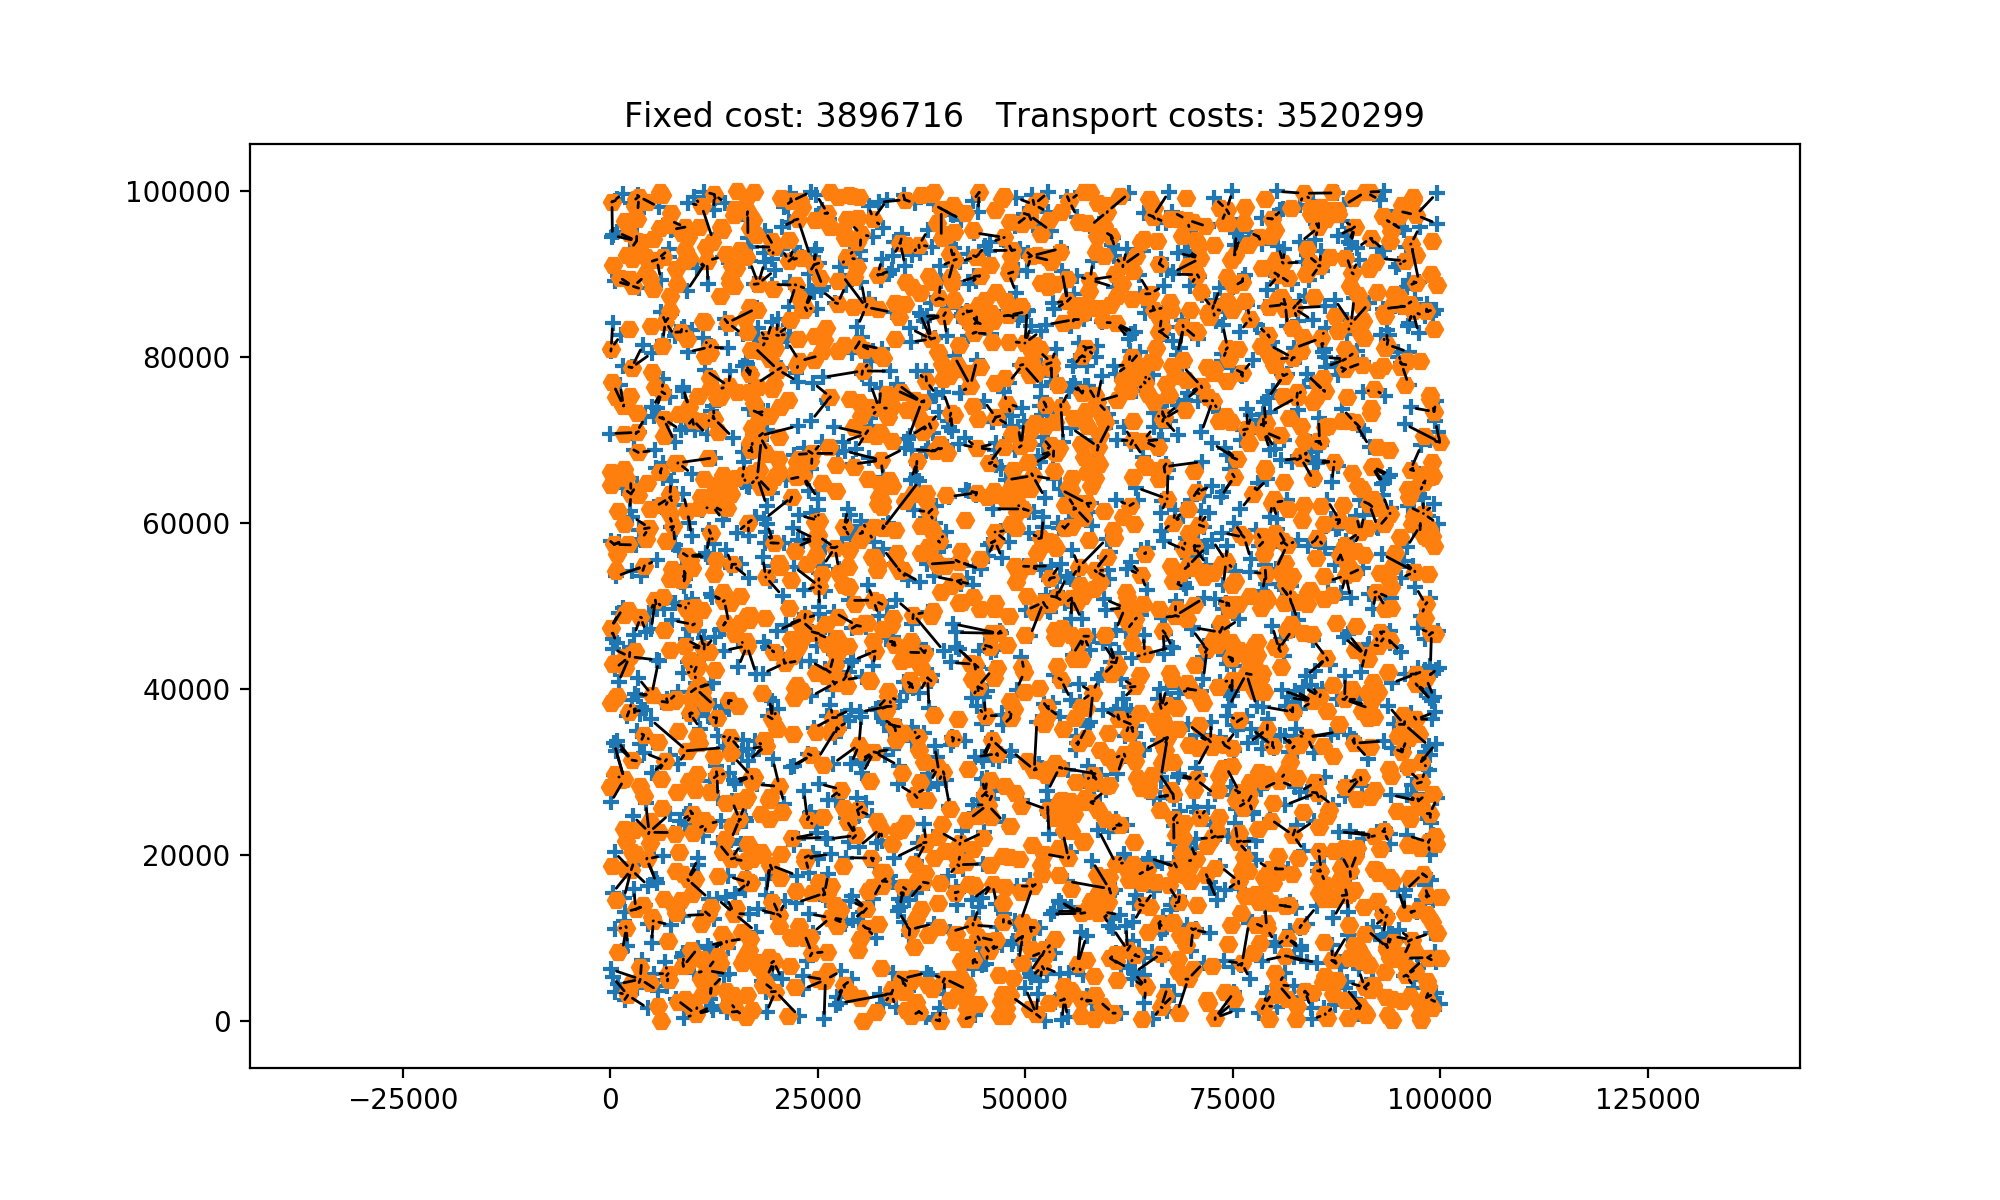

In [98]:
%matplotlib notebook
visualise_solution(data_dict, lns_problem_8_results_dict)